In [1]:
"""
Predict albedo and shading layer of an input image.
"""

import os
import sys
sys.path.append('./util')
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

__author__ = "Udo Dehm"
__copyright__ = "Copyright 2017"
__credits__ = ["Udo Dehm"]
__license__ = ""
__version__ = "0.1"
__maintainer__ = "Udo Dehm"
__email__ = "udo.dehm@mailbox.org"
__status__ = "Development"

In [2]:
def import_data(data_directory):
    dfs_train = {}
    dfs_valid = {}
    for file in os.listdir(data_directory):
        df_name = 'df_' + file[10:-4].replace('loss_', '').replace('_1', '').replace('invariant', 'inv')
        if 'valid' in file:
            df_name = df_name.replace('valid_', '')
            dfs_valid[df_name] = pd.read_csv(filepath_or_buffer=data_directory + file)
            dfs_valid[df_name].columns = dfs_valid[df_name].columns.str.replace(" ", "_").str.lower()
            dfs_valid[df_name]['wall_time'] = pd.to_datetime(dfs_valid[df_name]['wall_time'],unit='s')
        else:
            df_name = df_name.replace('_loss', '')
            if '_lambda' in df_name:
                df_name = df_name[:df_name.find('_lambda')]
            dfs_train[df_name] = pd.read_csv(filepath_or_buffer=data_directory + file)
            dfs_train[df_name].columns = dfs_train[df_name].columns.str.replace(" ", "_").str.lower()
            dfs_train[df_name]['wall_time'] = pd.to_datetime(dfs_train[df_name]['wall_time'],unit='s')
    return dfs_train, dfs_valid


def plot_all_loss_pairs(dfs_train, dfs_valid, logy=False, ylim_scale=5):
    for key in dfs_train:
        fig = plt.figure
        ax = dfs_train[key].plot(x='step', y='value', figsize=(12,7), 
                                 fontsize=14, legend=True, style='-',
                                 title=key[3:], logy=logy)
        dfs_valid[key].plot(x='step', y='value', style='-', ax=ax)
        ax.set_xlabel('step')
        ax.set_ylabel('loss')
        plt.ylim(0,ylim_scale*dfs_train[key]['value'].max())
        ax.legend(["training set", "validation set"], prop={'size': 14})
        # plt.savefig('foo.png', bbox_inches='tight')


def get_all_loss_model_data(data_dir, exclude_sub_dirs=[]):
    dfs_train = {}
    dfs_valid = {}
    dirs = [x for x in sorted(os.listdir(data_dir)) if x not in exclude_sub_dirs]
    for direc in dirs:
        dict_train, dict_valid = import_data(data_directory=data_dir + '/' + direc + '/')
        for key in dict_train:
            if key not in dfs_train:
                dfs_train[key] = pd.DataFrame()
                dfs_valid[key] = pd.DataFrame()
            dfs_train[key] = dfs_train[key].append(dict_train[key], ignore_index=True)
            dfs_valid[key] = dfs_valid[key].append(dict_valid[key], ignore_index=True)
    return dfs_train, dfs_valid


def get_minimum_loss(dfdict_train, dfdict_valid):
    print('Training loss:')
    dict_return_steps = {}
    dict_return_minloss = {}
    dict_return_cor_val_tr_step = {}
    dict_return_cor_val_tr_loss = {}
    for key, df in dfdict_train.items():
        minstep = df.loc[df['value'].idxmin(),'step']
        cor_valloss = dfdict_valid[key].loc[(dfdict_valid[key]['step'] - minstep).abs().idxmin()][['step', 'value']]
        print('{dfname} (step: {step}): {minloss:.5f} <-> corresponding valid loss: {valloss:.5f} (step: {valstep})'.format(dfname=key,
                                                              minloss=df['value'].min(),
                                                              step=minstep,
                                                              valloss=cor_valloss['value'],
                                                              valstep=cor_valloss['step']))
        dict_return_steps[key] = minstep
        dict_return_minloss[key] = df['value'].min()
        dict_return_cor_val_tr_step[key] = cor_valloss['step']
        dict_return_cor_val_tr_loss[key] = cor_valloss['value']
    dict_return = {}
    dict_return[('training', 'step')] = dict_return_steps
    dict_return[('training', 'minimum_loss')] = dict_return_minloss
    dict_return[('training', 'cor_val_tr_step')] = dict_return_cor_val_tr_step
    dict_return[('training', 'cor_val_tr_loss')] = dict_return_cor_val_tr_loss
        
        
    print('\nValidation loss:')
    dict_return_steps = {}
    dict_return_minloss = {}
    dict_return_cor_val_tr_step = {}
    dict_return_cor_val_tr_loss = {}
    for key, df in dfdict_valid.items():
        minstep = df.loc[df['value'].idxmin(),'step']
        cor_trainloss = dfdict_train[key].loc[(dfdict_train[key]['step'] - minstep).abs().idxmin()][['step', 'value']]
        print('{dfname} (step: {step}): {minloss:.5f} <-> corresponding train loss: {trainloss:.5f} (step: {trainstep})'.format(dfname=key,
                                                              minloss=df['value'].min(),
                                                              step=minstep,
                                                              trainloss=cor_trainloss['value'],
                                                              trainstep=cor_trainloss['step']))
        dict_return_steps[key] = minstep
        dict_return_minloss[key] = df['value'].min()
        dict_return_cor_val_tr_step[key] = cor_trainloss['step']
        dict_return_cor_val_tr_loss[key] = cor_trainloss['value']
    dict_return[('validation', 'step')] = dict_return_steps
    dict_return[('validation', 'minimum_loss')] = dict_return_minloss
    dict_return[('validation', 'cor_val_tr_step')] = dict_return_cor_val_tr_step
    dict_return[('validation', 'cor_val_tr_loss')] = dict_return_cor_val_tr_loss

    return pd.DataFrame(dict_return)


def find_file(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [3]:
logs_data_path = '/home/udo/image_decomposition/logs/logs_data/'

# Sintel:

In [4]:
logs_data_path_sintel = logs_data_path + 'sintel/'

## Resnet-50 narihira2015 (2 scale, reduced parameters):

Training loss:
df_l1 (step: 21400): 0.04206 <-> corresponding valid loss: 0.28019 (step: 21414)
df_l2_avg (step: 25800): 0.00199 <-> corresponding valid loss: 0.03887 (step: 25800)
df_berhu (step: 21400): 0.04235 <-> corresponding valid loss: 0.30654 (step: 21414)
df_l2 (step: 25800): 0.00248 <-> corresponding valid loss: 0.05663 (step: 25800)
df_l2_inv (step: 25800): 0.00151 <-> corresponding valid loss: 0.02111 (step: 25800)

Validation loss:
df_l1 (step: 4300): 0.25791 <-> corresponding train loss: 0.07706 (step: 4300)
df_l2_avg (step: 4300): 0.03783 <-> corresponding train loss: 0.00550 (step: 4300)
df_berhu (step: 4300): 0.28354 <-> corresponding train loss: 0.07787 (step: 4300)
df_l2 (step: 4300): 0.05532 <-> corresponding train loss: 0.00699 (step: 4300)
df_l2_inv (step: 4300): 0.02035 <-> corresponding train loss: 0.00400 (step: 4300)


/home/udo/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


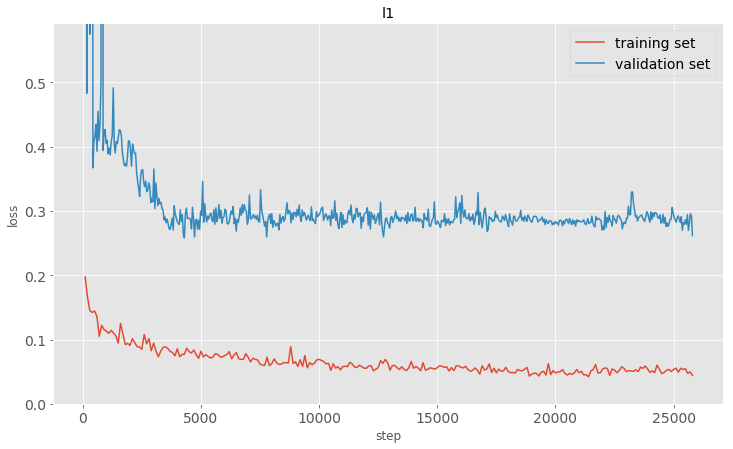

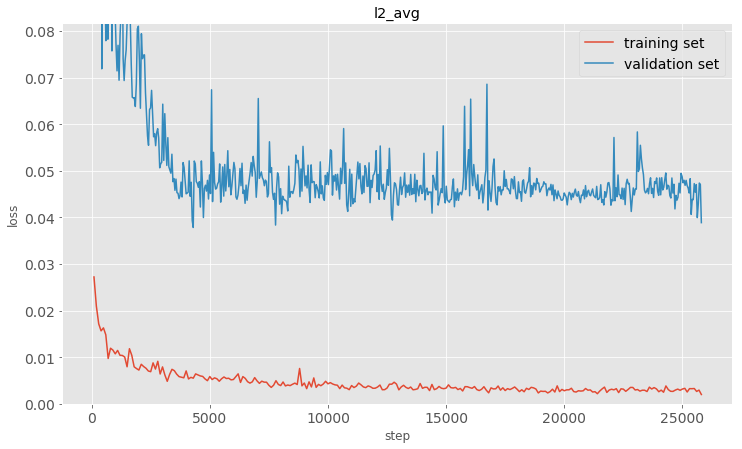

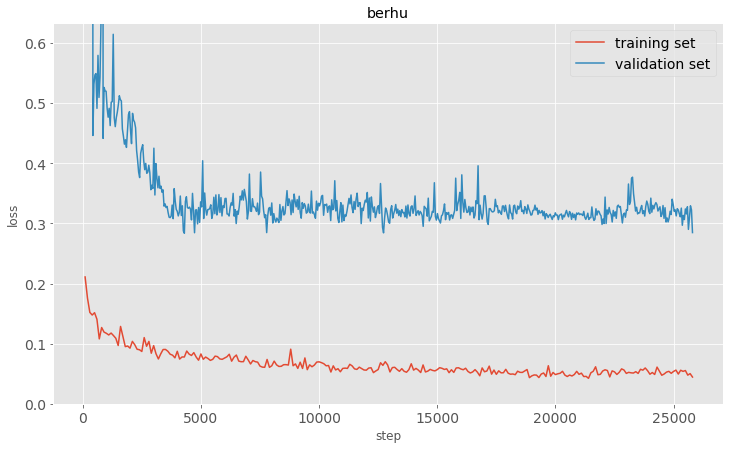

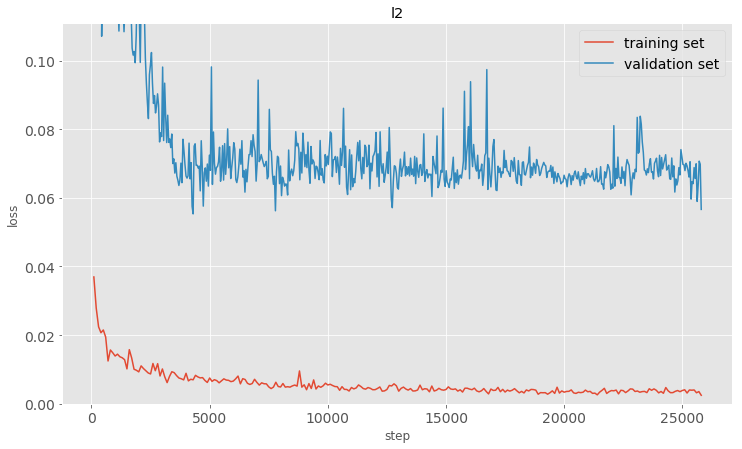

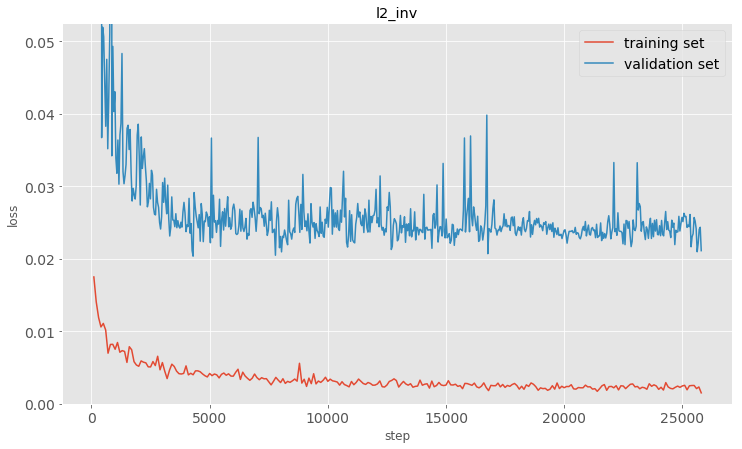

In [5]:
filepath = logs_data_path_sintel + 'slim_resnet_v1_50_narihira2015_reduced'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_resnet_v1_50_narihira2015_reduced, dfs_valid_resnet_v1_50_narihira2015_reduced = lst

df_minloss_res_nari = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015_reduced,
                                       dfdict_valid=dfs_valid_resnet_v1_50_narihira2015_reduced)
df_minloss_res_nari[('training', 'step_file')] = ('tfmodel-' + df_minloss_res_nari[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_nari[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_res_nari[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_nari.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015_reduced, logy=False, ylim_scale=3)

#### Old version of above:

Training loss:
df_l1 (step: 7000): 0.06166 <-> corresponding valid loss: 0.27247 (step: 7009)
df_l2_avg (step: 7000): 0.00402 <-> corresponding valid loss: 0.04152 (step: 7009)
df_berhu (step: 7000): 0.06245 <-> corresponding valid loss: 0.30368 (step: 7009)
df_l2 (step: 7000): 0.00497 <-> corresponding valid loss: 0.06109 (step: 7009)
df_l2_inv (step: 7000): 0.00307 <-> corresponding valid loss: 0.02195 (step: 7009)

Validation loss:
df_l1 (step: 4472): 0.25682 <-> corresponding train loss: 0.06622 (step: 4500)
df_l2_avg (step: 4472): 0.03718 <-> corresponding train loss: 0.00495 (step: 4500)
df_berhu (step: 4472): 0.28096 <-> corresponding train loss: 0.06741 (step: 4500)
df_l2 (step: 4472): 0.05482 <-> corresponding train loss: 0.00604 (step: 4500)
df_l2_inv (step: 4472): 0.01955 <-> corresponding train loss: 0.00385 (step: 4500)


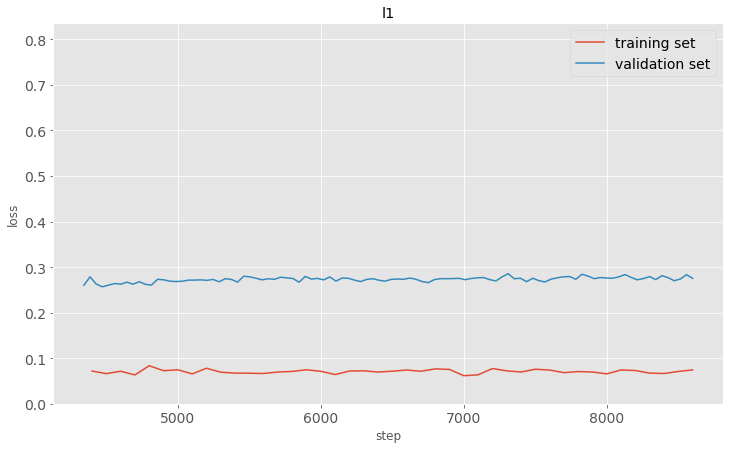

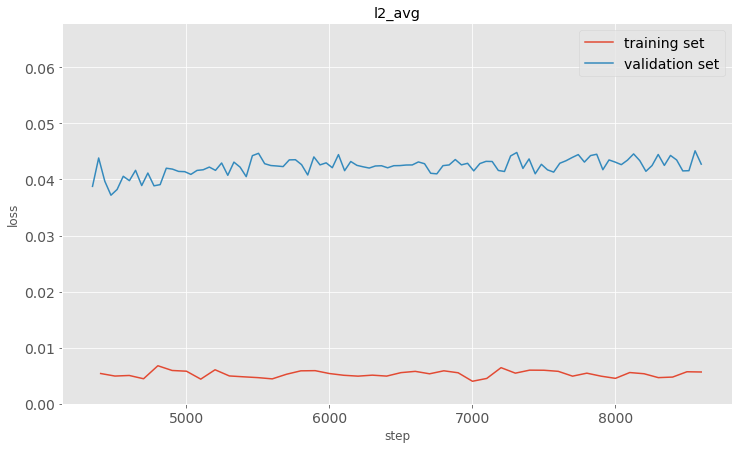

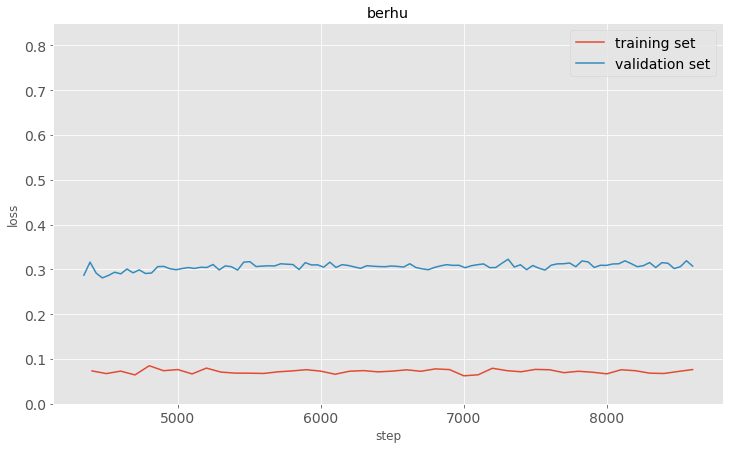

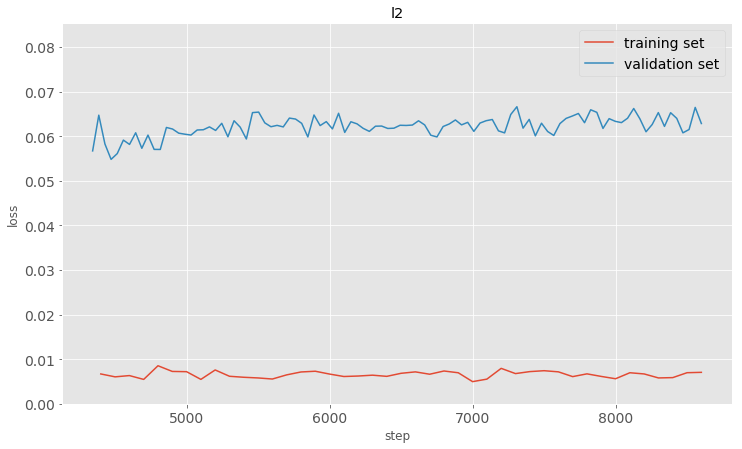

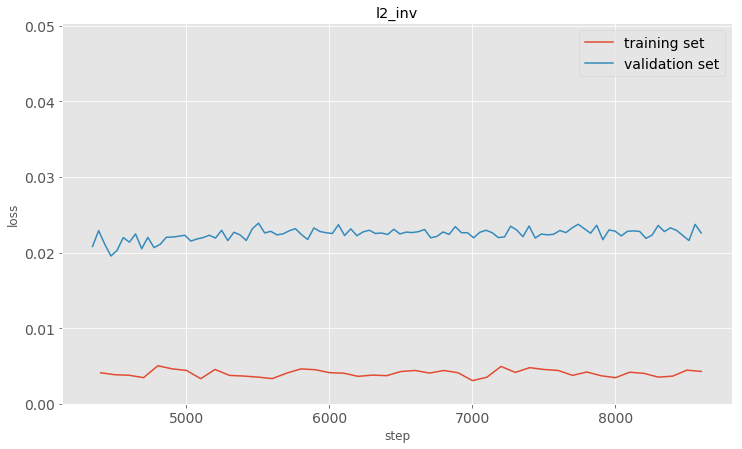

In [6]:
filepath = logs_data_path_sintel + 'old_slim_resnet_v1_50_narihira2015_reduced'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_resnet_v1_50_narihira2015_reduced_old, dfs_valid_resnet_v1_50_narihira2015_reduced_old = lst

df_minloss_res_nari_old = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015_reduced_old,
                                           dfdict_valid=dfs_valid_resnet_v1_50_narihira2015_reduced_old)
df_minloss_res_nari_old[('training', 'step_file')] = ('tfmodel-' + df_minloss_res_nari_old[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_nari_old[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_res_nari_old[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_nari_old.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015_reduced_old, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015_reduced_old, logy=False, ylim_scale=10)

## Resnet-50 up-projection:

Training loss:
df_l1 (step: 16600): 0.06276 <-> corresponding valid loss: 0.30115 (step: 16598)
df_l2_avg (step: 17200): 0.72269 <-> corresponding valid loss: 3.89289 (step: 17200)
df_berhu (step: 10900): 0.06876 <-> corresponding valid loss: 0.40499 (step: 10879)
df_l2 (step: 17200): 0.72447 <-> corresponding valid loss: 3.91508 (step: 17200)
df_l2_inv (step: 17200): 0.72090 <-> corresponding valid loss: 3.87070 (step: 17200)

Validation loss:
df_l1 (step: 17114): 0.27076 <-> corresponding train loss: 0.11322 (step: 17100)
df_l2_avg (step: 15523): 0.04357 <-> corresponding train loss: 0.79740 (step: 15500)
df_berhu (step: 10621): 0.31395 <-> corresponding train loss: 0.08260 (step: 10600)
df_l2 (step: 15523): 0.06399 <-> corresponding train loss: 0.79869 (step: 15500)
df_l2_inv (step: 13502): 0.02315 <-> corresponding train loss: 0.84739 (step: 13500)


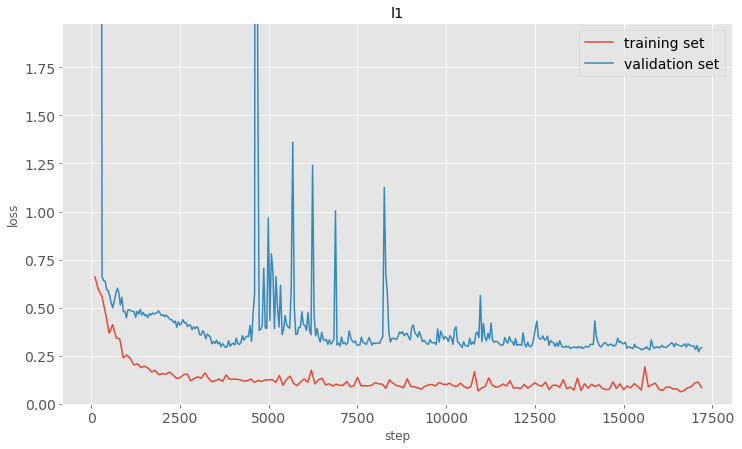

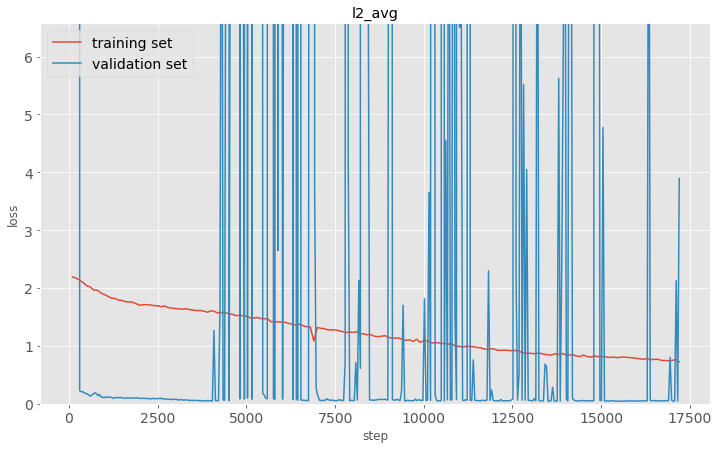

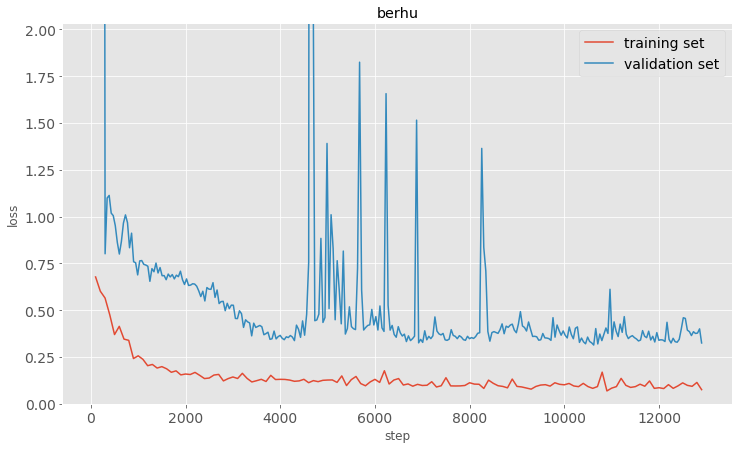

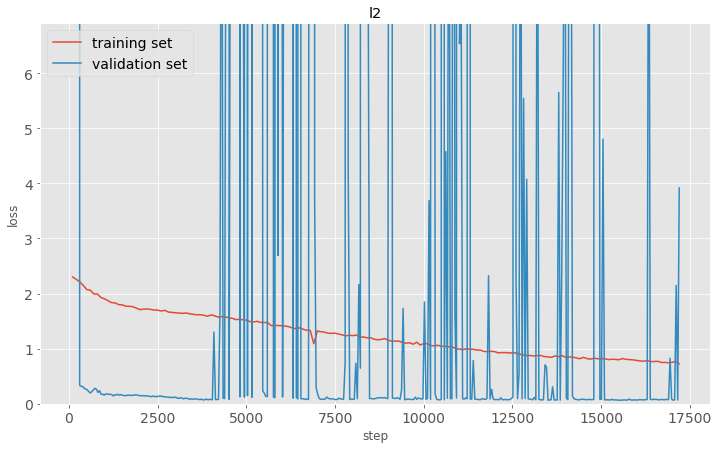

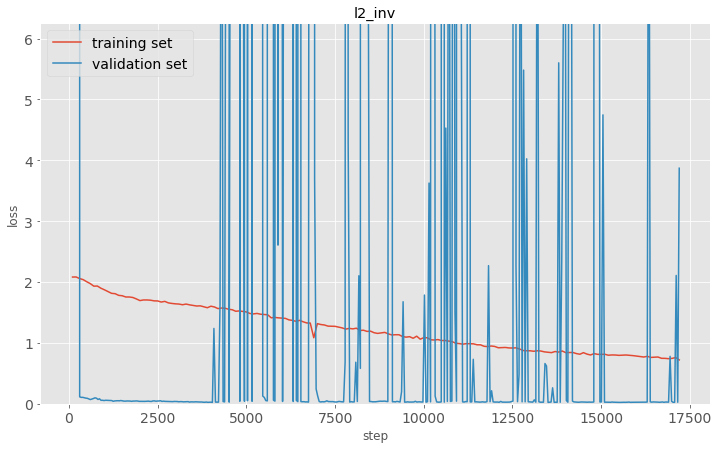

In [7]:
filepath = logs_data_path_sintel + 'slim_resnet_v1_50_up_projection'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_resnet_v1_50_upproject, dfs_valid_resnet_v1_50_upproject = lst

df_minloss_res_upprojection = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_upproject,
                                               dfdict_valid=dfs_valid_resnet_v1_50_upproject)
df_minloss_res_upprojection[('training', 'step_file')] = ('tfmodel-' + df_minloss_res_upprojection[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_upprojection[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_res_upprojection[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_upprojection.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_upproject, 
                    dfs_valid=dfs_valid_resnet_v1_50_upproject, logy=False, ylim_scale=3)

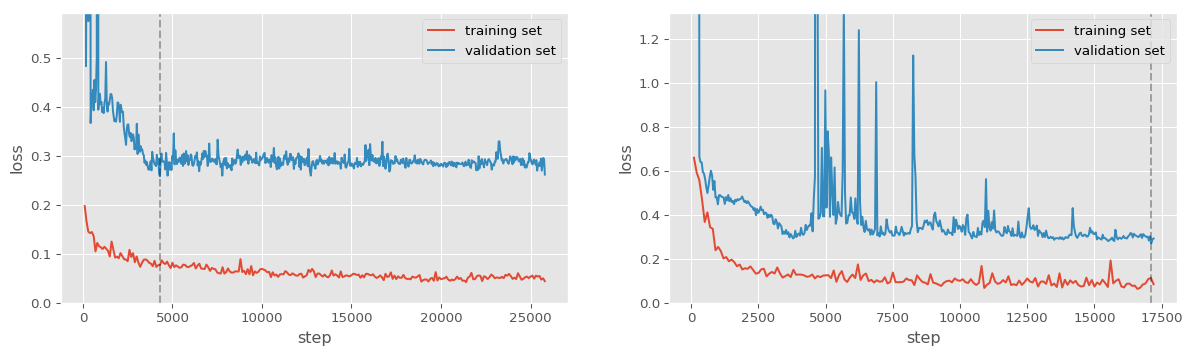

In [8]:
k=1
cols=2
f, axarr = plt.subplots(k, cols, figsize=(15, 4), dpi=96)
dfs_train_resnet_v1_50_narihira2015_reduced['df_l1'].plot(x='step', y='value', #figsize=(12,7), 
                                                           fontsize=10, legend=True, style='-',
                                                           title='', logy=False, ax=axarr[0])
dfs_valid_resnet_v1_50_narihira2015_reduced['df_l1'].plot(x='step', y='value', style='-', ax=axarr[0])
axarr[0].axvline(x=4300, ls='--', alpha=0.3, c='k')
axarr[0].set_xlabel('step')
axarr[0].set_ylabel('loss')
axarr[0].set_ylim(0,3*dfs_train_resnet_v1_50_narihira2015_reduced['df_l1']['value'].max())
axarr[0].legend(["training set", "validation set"], prop={'size': 10})


dfs_train_resnet_v1_50_upproject['df_l1'].plot(x='step', y='value',# figsize=(12,7), 
                                                           fontsize=10, legend=True, style='-',
                                                           title='', logy=False, ax=axarr[1])
dfs_valid_resnet_v1_50_upproject['df_l1'].plot(x='step', y='value', style='-', ax=axarr[1])
axarr[1].axvline(x=17114, ls='--', alpha=0.3, c='k')
axarr[1].set_xlabel('step')
axarr[1].set_ylabel('loss')
axarr[1].set_ylim(0,2*dfs_train_resnet_v1_50_upproject['df_l1']['value'].max())
axarr[1].legend(["training set", "validation set"], prop={'size': 10})
plt.savefig('figures/loss_l1_resnet_narihira_and_upproject.pdf', bbox_inches='tight', dpi='figure')

## Resnet-50 deconv decoder (1 scale, reduced parameters):

Training loss:
df_l1 (step: 16600): 0.06813 <-> corresponding valid loss: 0.28823 (step: 16598)
df_l2_avg (step: 16600): 0.00548 <-> corresponding valid loss: 0.04558 (step: 16598)
df_berhu (step: 16600): 0.06963 <-> corresponding valid loss: 0.32215 (step: 16598)
df_l2 (step: 16600): 0.00664 <-> corresponding valid loss: 0.06720 (step: 16598)
df_l2_inv (step: 16600): 0.00432 <-> corresponding valid loss: 0.02397 (step: 16598)

Validation loss:
df_l1 (step: 3999): 0.27212 <-> corresponding train loss: 0.10765 (step: 4000)
df_l2_avg (step: 14276): 0.04216 <-> corresponding train loss: 0.00829 (step: 14300)
df_berhu (step: 17587): 0.28485 <-> corresponding train loss: 0.09452 (step: 17600)
df_l2 (step: 14276): 0.06271 <-> corresponding train loss: 0.01011 (step: 14300)
df_l2_inv (step: 14276): 0.02161 <-> corresponding train loss: 0.00647 (step: 14300)


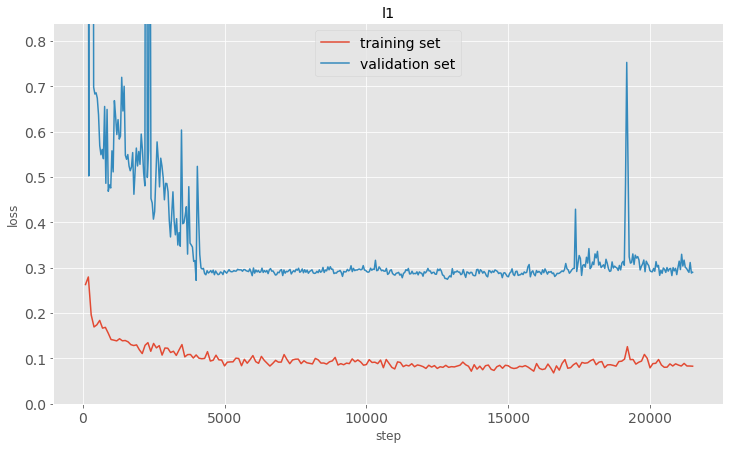

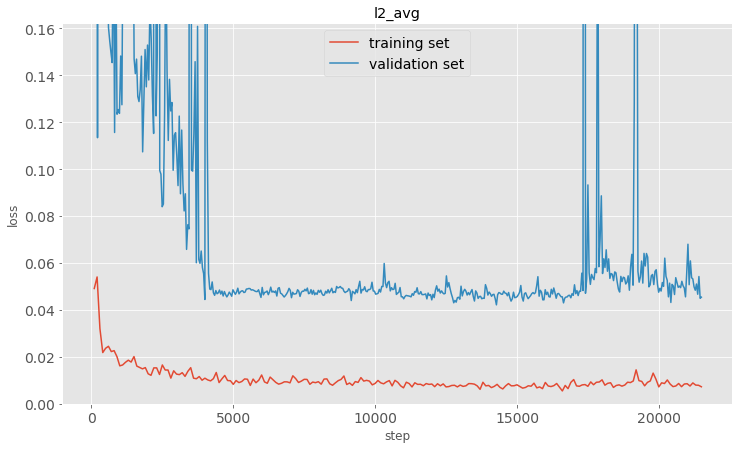

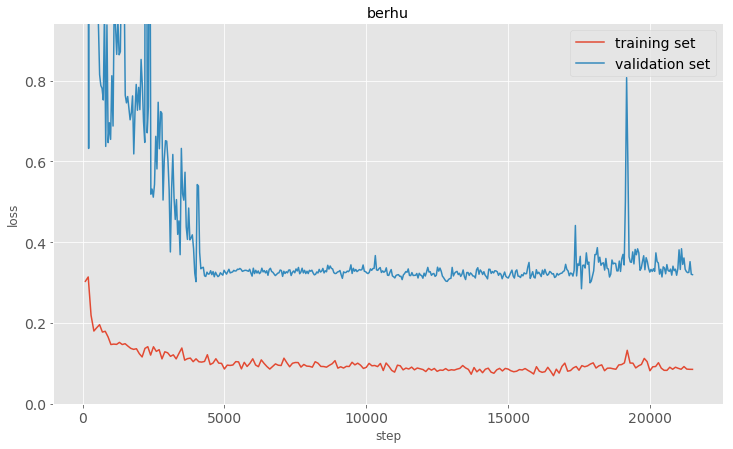

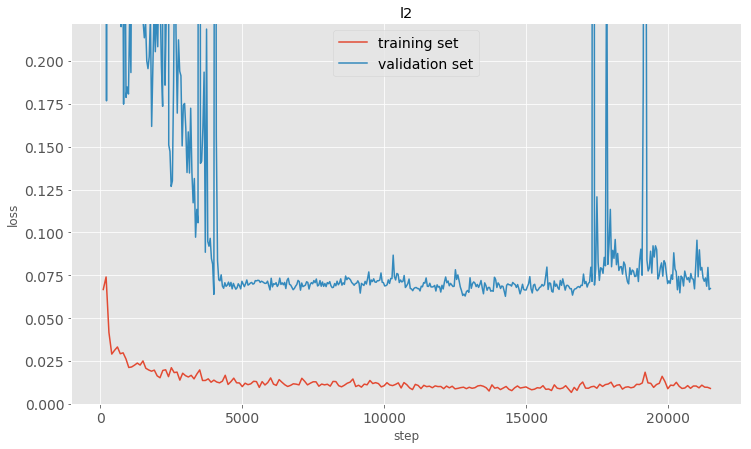

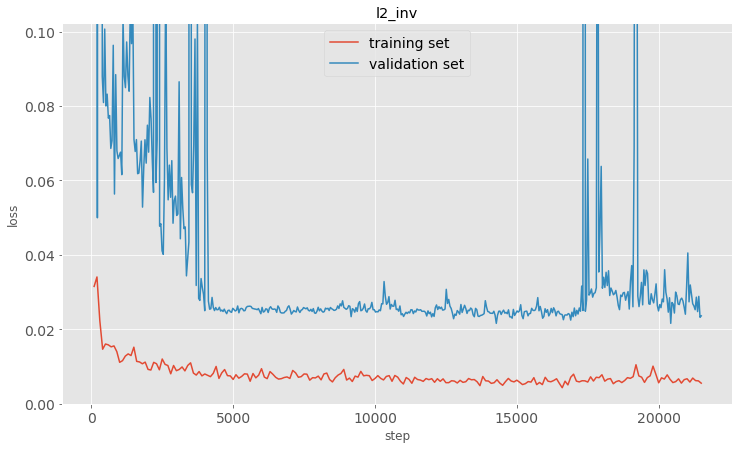

In [9]:
filepath = logs_data_path_sintel + 'slim_resnet_v1_50_deconv_decoder_reduced'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_resnet_v1_50_deconv_decoder_reduced, dfs_valid_resnet_v1_50_deconv_decoder_reduced = lst

df_minloss_res_deconv = get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_reduced,
                                         dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced)
df_minloss_res_deconv[('training', 'step_file')] = ('tfmodel-' + df_minloss_res_deconv[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_deconv[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_res_deconv[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_res_deconv.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_reduced, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_reduced, logy=False, ylim_scale=3)

## VGG-16 narihira2015 (2 scale, reduced parameters):

Training loss:
df_l1 (step: 12300): 0.06264 <-> corresponding valid loss: 0.31049 (step: 12298)
df_l2_avg (step: 12300): 0.00405 <-> corresponding valid loss: 0.05814 (step: 12298)
df_berhu (step: 12300): 0.06343 <-> corresponding valid loss: 0.35058 (step: 12298)
df_l2 (step: 12300): 0.00503 <-> corresponding valid loss: 0.08334 (step: 12298)
df_l2_inv (step: 12300): 0.00307 <-> corresponding valid loss: 0.03294 (step: 12298)

Validation loss:
df_l1 (step: 12771): 0.28845 <-> corresponding train loss: 0.07636 (step: 12800)
df_l2_avg (step: 12771): 0.05134 <-> corresponding train loss: 0.00562 (step: 12800)
df_berhu (step: 12771): 0.32275 <-> corresponding train loss: 0.07746 (step: 12800)
df_l2 (step: 12771): 0.07305 <-> corresponding train loss: 0.00708 (step: 12800)
df_l2_inv (step: 12771): 0.02963 <-> corresponding train loss: 0.00416 (step: 12800)


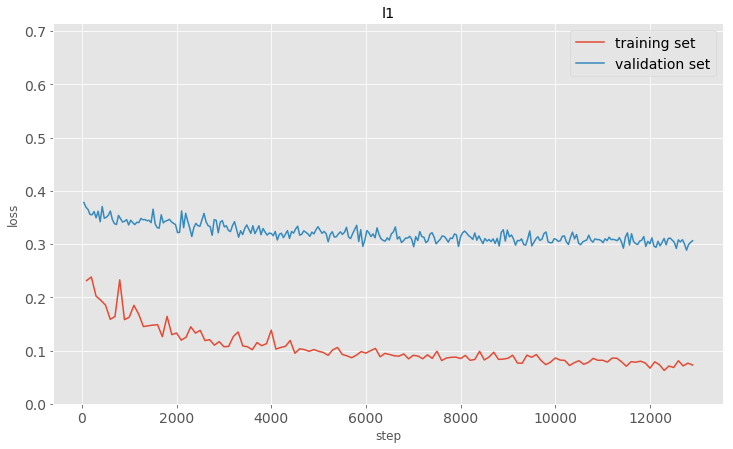

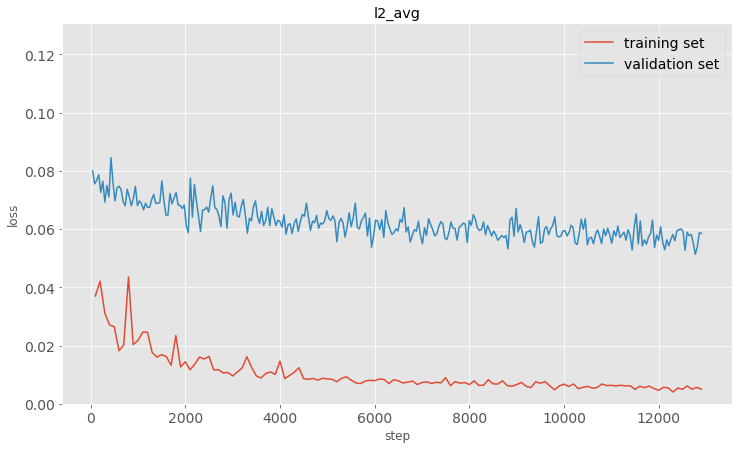

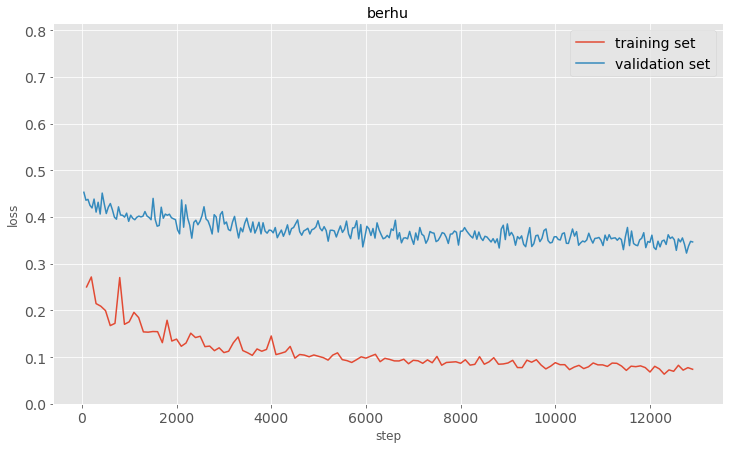

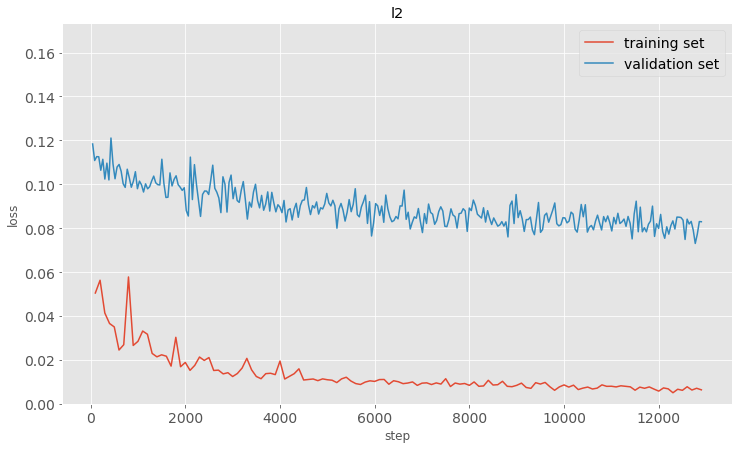

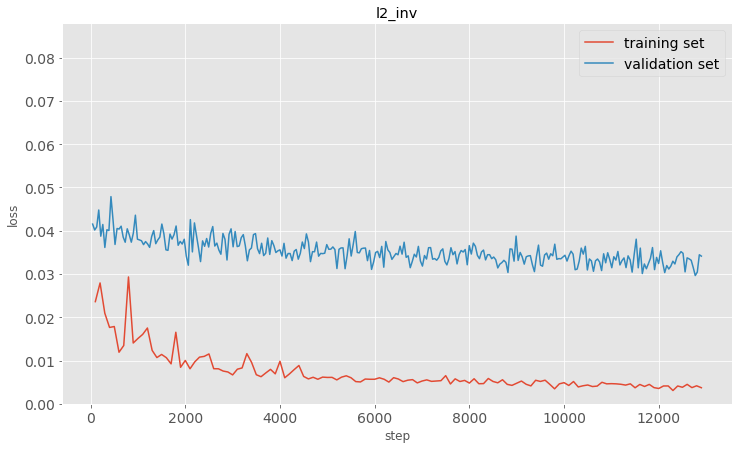

In [10]:
filepath=logs_data_path_sintel + 'slim_vgg16_narihira2015_reduced_bn'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_vgg16_narihira2015_reduced_bn, dfs_valid_vgg16_narihira2015_reduced_bn = lst

df_minloss_vgg_nari = get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015_reduced_bn,
                                       dfdict_valid=dfs_valid_vgg16_narihira2015_reduced_bn)
df_minloss_vgg_nari[('training', 'step_file')] = ('tfmodel-' + df_minloss_vgg_nari[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_vgg_nari[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_vgg_nari[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_vgg_nari.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015_reduced_bn, 
                    dfs_valid=dfs_valid_vgg16_narihira2015_reduced_bn, logy=False, ylim_scale=3)

## VGG-16 deconv decoder (1 scale, reduced parameters, bn):

Training loss:
df_l1 (step: 11400): 0.08655 <-> corresponding valid loss: 0.30151 (step: 11395)
df_l2_avg (step: 11400): 0.00877 <-> corresponding valid loss: 0.05490 (step: 11395)
df_berhu (step: 11400): 0.08974 <-> corresponding valid loss: 0.34865 (step: 11395)
df_l2 (step: 11400): 0.01065 <-> corresponding valid loss: 0.07859 (step: 11395)
df_l2_inv (step: 11400): 0.00690 <-> corresponding valid loss: 0.03120 (step: 11395)

Validation loss:
df_l1 (step: 11481): 0.28914 <-> corresponding train loss: 0.09907 (step: 11500)
df_l2_avg (step: 8600): 0.05149 <-> corresponding train loss: 0.01164 (step: 8600)
df_berhu (step: 8600): 0.33092 <-> corresponding train loss: 0.11232 (step: 8600)
df_l2 (step: 11481): 0.07362 <-> corresponding train loss: 0.01302 (step: 11500)
df_l2_inv (step: 8600): 0.02909 <-> corresponding train loss: 0.00873 (step: 8600)


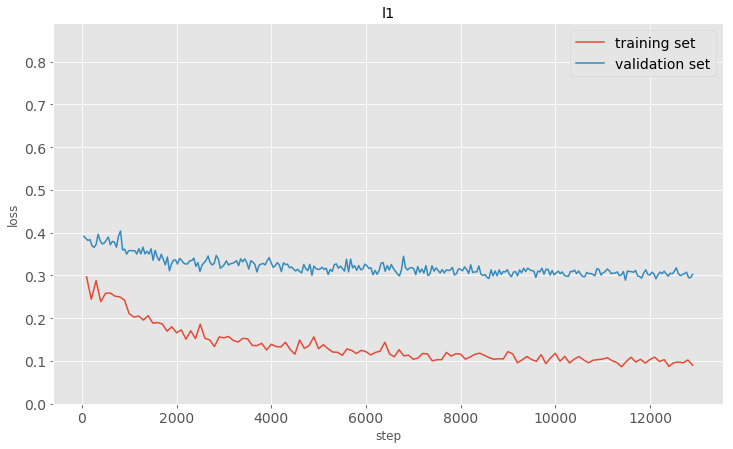

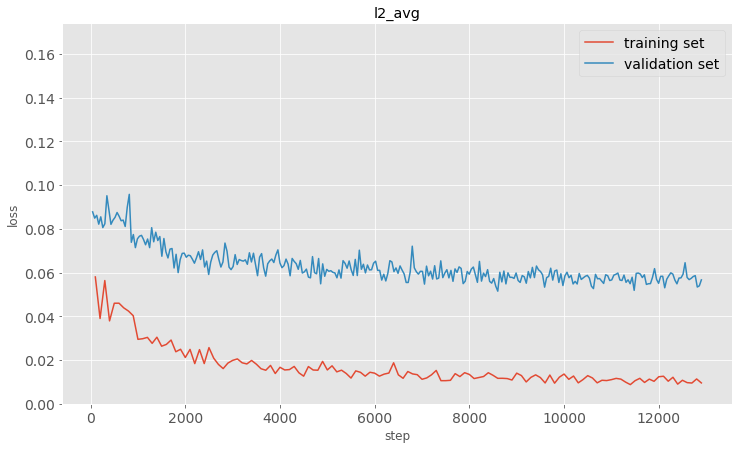

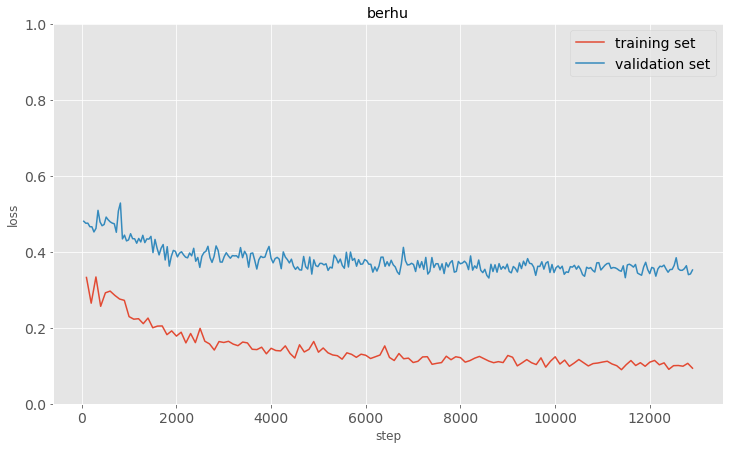

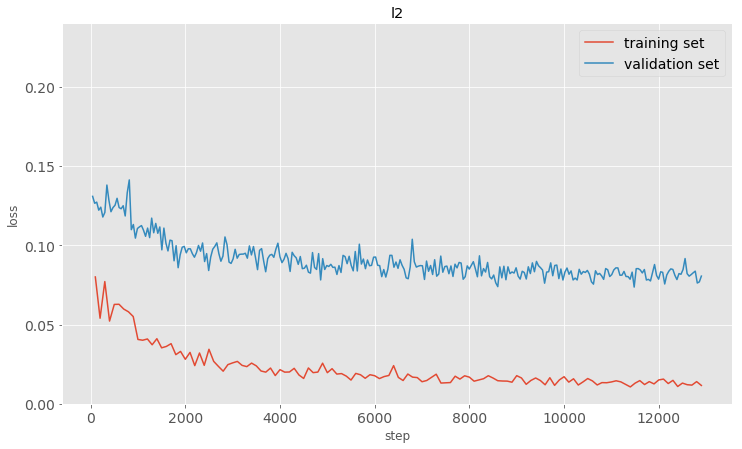

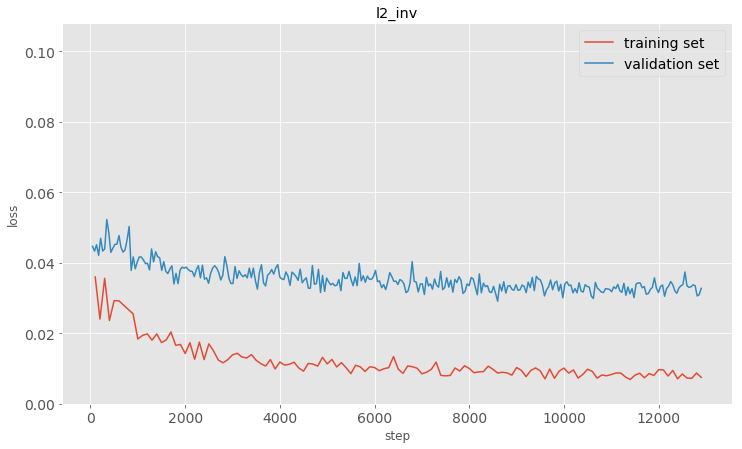

In [11]:
filepath = logs_data_path_sintel + 'slim_vgg16_deconv_decoder_reduced_bn'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_vgg16_deconv_decoder_reduced_bn, dfs_valid_vgg16_deconv_decoder_reduced_bn = lst

df_minloss_vgg_deconv = get_minimum_loss(dfdict_train=dfs_train_vgg16_deconv_decoder_reduced_bn,
                                         dfdict_valid=dfs_valid_vgg16_deconv_decoder_reduced_bn)
df_minloss_vgg_deconv[('training', 'step_file')] = ('tfmodel-' + df_minloss_vgg_deconv[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_vgg_deconv[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_vgg_deconv[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_vgg_deconv.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_deconv_decoder_reduced_bn, 
                    dfs_valid=dfs_valid_vgg16_deconv_decoder_reduced_bn, logy=False, ylim_scale=3)

## Sintel dataset analysis

In [12]:
df_minloss_res_nari['model'] = 'resnet_narihira'
df_minloss_res_nari.set_index('model', append=True, inplace=True)

df_minloss_res_upprojection['model'] = 'resnet_upprojection'
df_minloss_res_upprojection.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_minloss_res_nari.append(df_minloss_res_upprojection)

df_minloss_res_deconv['model'] = 'resnet_deconv'
df_minloss_res_deconv.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_sintel_analysis.append(df_minloss_res_deconv)

df_minloss_vgg_nari['model'] = 'vgg_narihira'
df_minloss_vgg_nari.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_sintel_analysis.append(df_minloss_vgg_nari)

df_minloss_vgg_deconv['model'] = 'vgg_deconv'
df_minloss_vgg_deconv.set_index('model', append=True, inplace=True)
df_sintel_analysis = df_sintel_analysis.append(df_minloss_vgg_deconv)

df_sintel_analysis.sort_index(inplace=True)
df_sintel_analysis.index.names = ['loss_type', 'model']

In [13]:
df_sintel_analysis

training                               \
                              cor_val_tr_loss cor_val_tr_step minimum_loss   
loss_type model                                                              
df_berhu  resnet_deconv              0.322146           16598     0.069629   
          resnet_narihira            0.306535           21414     0.042345   
          resnet_upprojection        0.404992           10879     0.068755   
          vgg_deconv                 0.348651           11395     0.089743   
          vgg_narihira               0.350577           12298     0.063429   
df_l1     resnet_deconv              0.288227           16598     0.068132   
          resnet_narihira            0.280186           21414     0.042061   
          resnet_upprojection        0.301155           16598     0.062758   
          vgg_deconv                 0.301514           11395     0.086549   
          vgg_narihira               0.310488           12298     0.062643   
df_l2     resnet_deconv              0.067197           16598     0.006642   
          resnet_narihira            0.056630           25800     0.002482   
          resnet_upprojection        3.915077           17200     0.724471   
          vgg_deconv                 0.078588           11395     0.010649   
          vgg_narihira               0.083337           12298     0.005034   
df_l2_avg resnet_deconv              0.045583           16598     0.005479   
          resnet_narihira            0.038871           25800     0.001995   
          resnet_upprojection        3.892890           17200     0.722687   
          vgg_deconv                 0.054896           11395     0.008773   
          vgg_narihira               0.058140           12298     0.004050   
df_l2_inv resnet_deconv              0.023969           16598     0.004316   
          resnet_narihira            0.021111           25800     0.001507   
          resnet_upprojection        3.870704           17200     0.720904   
          vgg_deconv                 0.031203           11395     0.006897   
          vgg_narihira               0.032943           12298     0.003067   

                                      \
                                step   
loss_type model                        
df_berhu  resnet_deconv        16600   
          resnet_narihira      21400   
          resnet_upprojection  10900   
          vgg_deconv           11400   
          vgg_narihira         12300   
df_l1     resnet_deconv        16600   
          resnet_narihira      21400   
          resnet_upprojection  16600   
          vgg_deconv           11400   
          vgg_narihira         12300   
df_l2     resnet_deconv        16600   
          resnet_narihira      25800   
          resnet_upprojection  17200   
          vgg_deconv           11400   
          vgg_narihira         12300   
df_l2_avg resnet_deconv        16600   
          resnet_narihira      25800   
          resnet_upprojection  17200   
          vgg_deconv           11400   
          vgg_narihira         12300   
df_l2_inv resnet_deconv        16600   
          resnet_narihira      25800   
          resnet_upprojection  17200   
          vgg_deconv           11400   
          vgg_narihira         12300   

                                                                                  \
                                                                       step_file   
loss_type model                                                                    
df_berhu  resnet_deconv        /home/udo/image_decomposition/logs/sintel/slim...   
          resnet_narihira      /home/udo/image_decomposition/logs/sintel/slim...   
          resnet_upprojection  /home/udo/image_decomposition/logs/sintel/slim...   
          vgg_deconv           /home/udo/image_decomposition/logs/sintel/slim...   
          vgg_narihira         /home/udo/image_decomposition/logs/sintel/slim...   
df_l1     resnet_deconv        /home/udo/image_decompositio

In [14]:
dict_literature = {('MSE', 'albedo'): {'Baseline: Shading Constant': 0.0531,
                                       'Baseline: Albedo Constant': 0.0369,
                                       'Retinex \cite{grosse2009}': 0.0606,
                                       'Lee et al. \cite{lee2012}': 0.0463,
                                       'Barron et al. \cite{barron2015}': 0.0420,
                                       'Chen and Koltun \cite{chen2013}': 0.0307,
                                       'Narihira et al. \cite{narihira2015}': 0.0201},
                   ('MSE', 'shading'): {'Baseline: Shading Constant': 0.0488,
                                        'Baseline: Albedo Constant': 0.0378,
                                        'Retinex \cite{grosse2009}': 0.0727,
                                        'Lee et al. \cite{lee2012}': 0.0507,
                                        'Barron et al. \cite{barron2015}': 0.0436,
                                        'Chen and Koltun \cite{chen2013}': 0.0277,
                                        'Narihira et al. \cite{narihira2015}': 0.0224},
                  }
df_literature = pd.DataFrame.from_dict(dict_literature, orient='Index')
df_literature = df_literature[['Baseline: Shading Constant', 'Baseline: Albedo Constant', 
                               'Retinex \cite{grosse2009}', 'Lee et al. \cite{lee2012}', 
                               'Barron et al. \cite{barron2015}',
                               'Chen and Koltun \cite{chen2013}',
                               'Narihira et al. \cite{narihira2015}']].transpose()
means = df_literature.mean(axis=1)
sums = df_literature.sum(axis=1)
df_literature[('MSE', 'avg')] = means
df_literature[('MSE', 'sum')] = sums

Save to files:

In [15]:
df_sintel_analysis.to_pickle(path='figures/df_sintel_loss_analysis.pkl')
df_literature.to_pickle(path='figures/df_literature_loss_comparison_sintel.pkl')
with open("figures/table_literature_loss_comparison_sintel.tex", "w") as f:
    print(df_literature.to_latex(escape=False), file=f)

## Resnet-50 narihira2015 (2 scale):

Training loss:
df_l1 (step: 600): 0.11198 <-> corresponding valid loss: 0.38910 (step: 602)
df_l2_avg (step: 600): 0.01135 <-> corresponding valid loss: 0.07925 (step: 602)
df_berhu (step: 600): 0.11570 <-> corresponding valid loss: 0.46161 (step: 602)
df_l2 (step: 600): 0.01449 <-> corresponding valid loss: 0.11855 (step: 602)
df_l2_inv (step: 600): 0.00820 <-> corresponding valid loss: 0.03995 (step: 602)

Validation loss:
df_l1 (step: 602): 0.38910 <-> corresponding train loss: 0.11198 (step: 600)
df_l2_avg (step: 602): 0.07925 <-> corresponding train loss: 0.01135 (step: 600)
df_berhu (step: 602): 0.46161 <-> corresponding train loss: 0.11570 (step: 600)
df_l2 (step: 602): 0.11855 <-> corresponding train loss: 0.01449 (step: 600)
df_l2_inv (step: 602): 0.03995 <-> corresponding train loss: 0.00820 (step: 600)


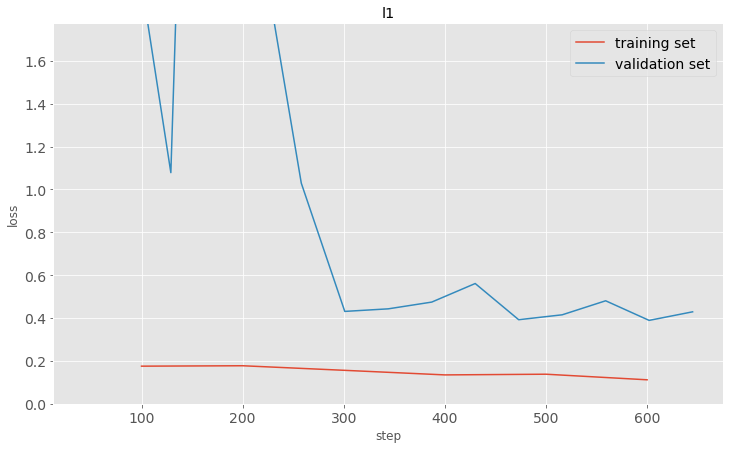

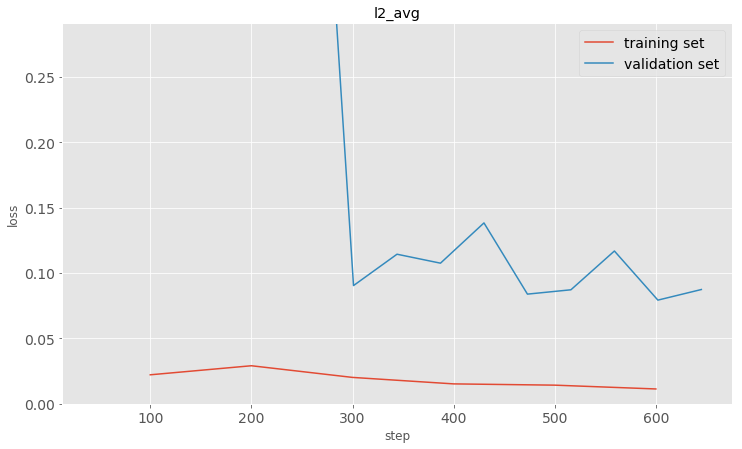

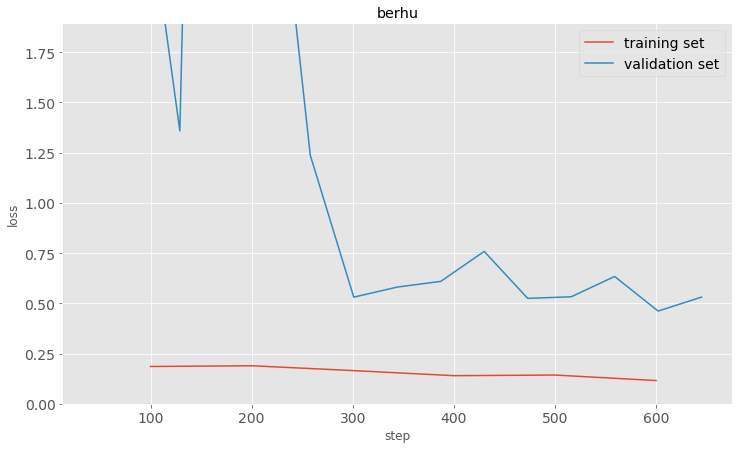

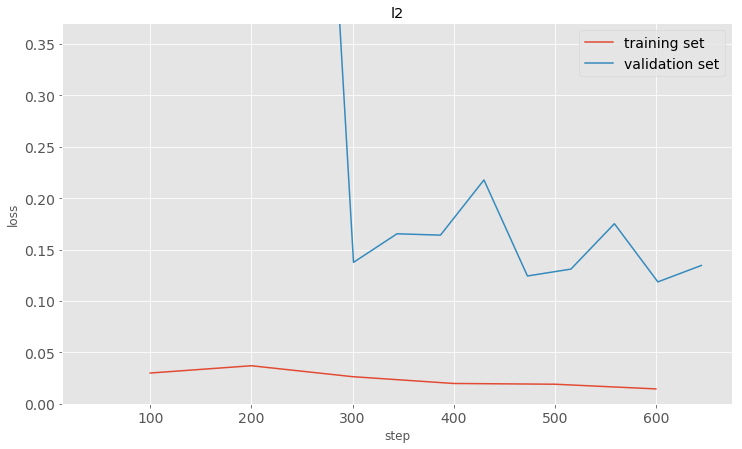

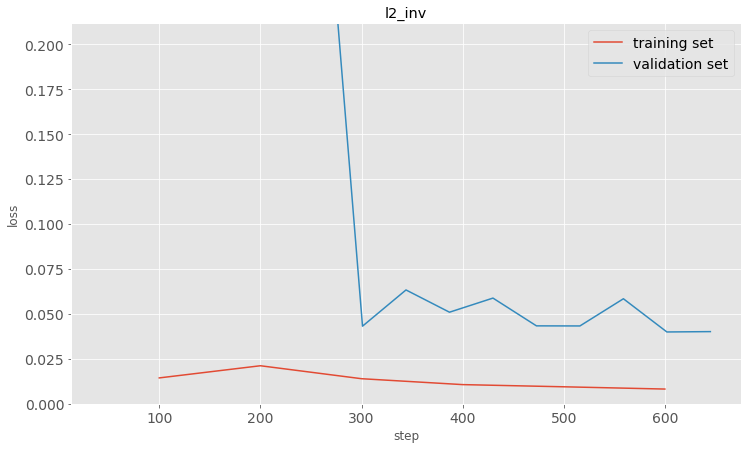

In [16]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_narihira2015')
dfs_train_resnet_v1_50_narihira2015, dfs_valid_resnet_v1_50_narihira2015 = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_narihira2015,
                 dfdict_valid=dfs_valid_resnet_v1_50_narihira2015)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_narihira2015, 
                    dfs_valid=dfs_valid_resnet_v1_50_narihira2015, 
                    logy=False, ylim_scale=10)

## Resnet-50 deconv decoder (1 scale):

Training loss:
df_l1 (step: 7900): 0.06269 <-> corresponding valid loss: 0.29473 (step: 7912)
df_l2_avg (step: 6300): 0.00488 <-> corresponding valid loss: 0.04488 (step: 6321)
df_berhu (step: 7900): 0.06393 <-> corresponding valid loss: 0.33038 (step: 7912)
df_l2 (step: 6300): 0.00589 <-> corresponding valid loss: 0.06638 (step: 6321)
df_l2_inv (step: 6300): 0.00388 <-> corresponding valid loss: 0.02339 (step: 6321)

Validation loss:
df_l1 (step: 8514): 0.27598 <-> corresponding train loss: 0.07868 (step: 8500)
df_l2_avg (step: 8514): 0.04343 <-> corresponding train loss: 0.00700 (step: 8500)
df_berhu (step: 8514): 0.30342 <-> corresponding train loss: 0.08040 (step: 8500)
df_l2 (step: 8514): 0.06334 <-> corresponding train loss: 0.00855 (step: 8500)
df_l2_inv (step: 4085): 0.02283 <-> corresponding train loss: 0.00607 (step: 4100)


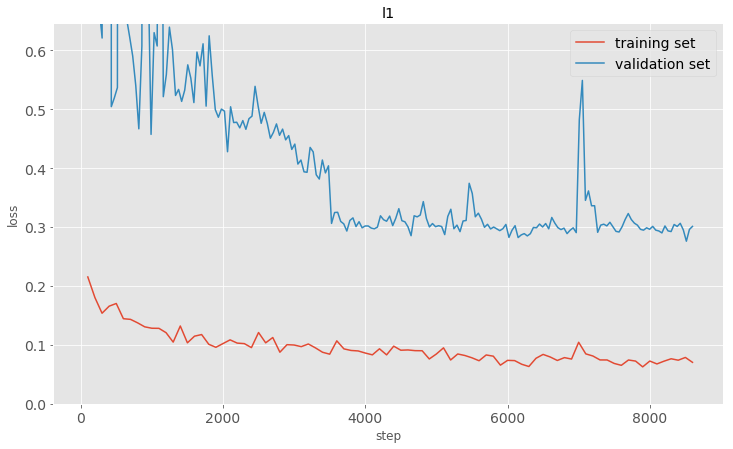

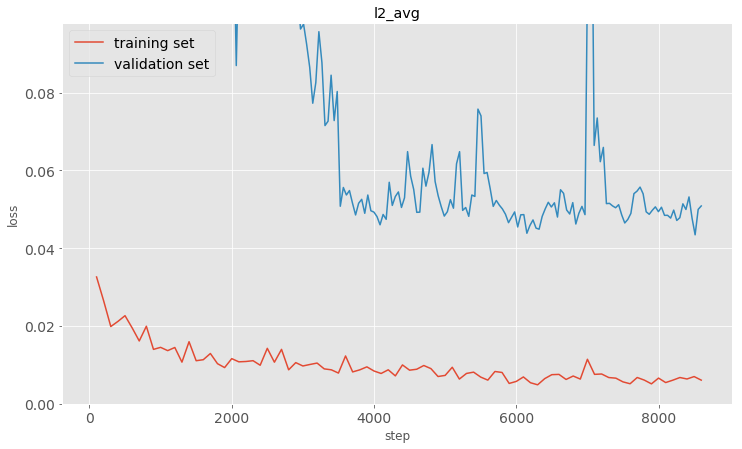

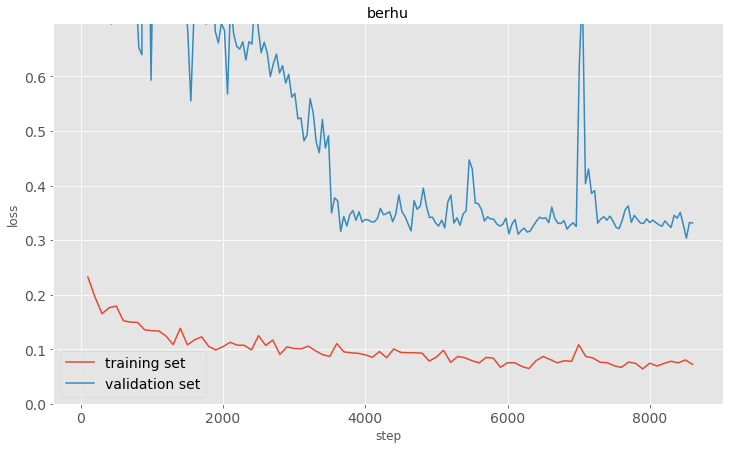

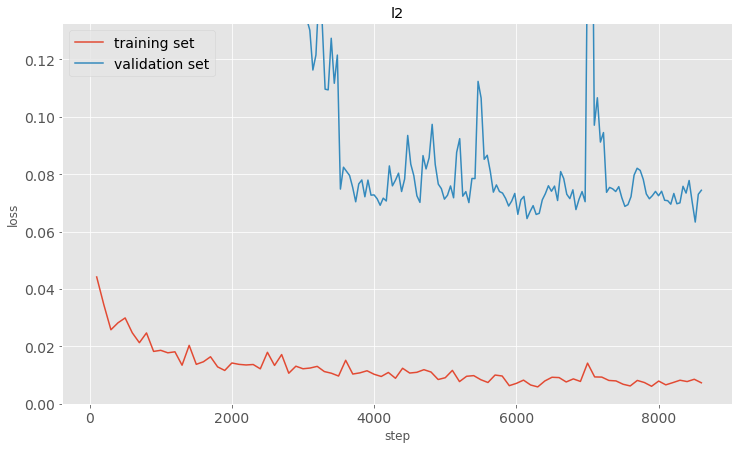

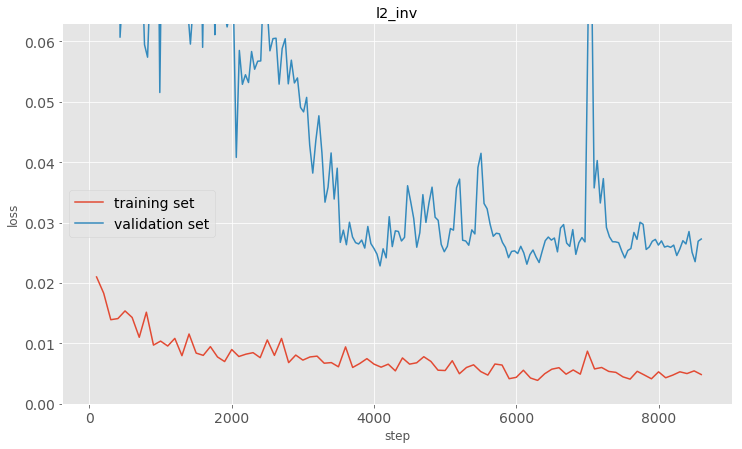

In [17]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_resnet_v1_50_deconv_decoder')
dfs_train_resnet_v1_50_deconv_decoder, dfs_valid_resnet_v1_50_deconv_decoder = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder, logy=False, ylim_scale=3)

## VGG-16 Narihira2015 (2 scale):

Training loss:
df_l1 (step: 8400): 0.05335 <-> corresponding valid loss: 0.30025 (step: 8385)
df_l2_avg (step: 8400): 0.00336 <-> corresponding valid loss: 0.05189 (step: 8385)
df_berhu (step: 8400): 0.05397 <-> corresponding valid loss: 0.34866 (step: 8385)
df_l2 (step: 8400): 0.00407 <-> corresponding valid loss: 0.07606 (step: 8385)
df_l2_inv (step: 8400): 0.00265 <-> corresponding valid loss: 0.02773 (step: 8385)

Validation loss:
df_l1 (step: 1677): 0.28213 <-> corresponding train loss: 0.11423 (step: 1700)
df_l2_avg (step: 1677): 0.04468 <-> corresponding train loss: 0.01155 (step: 1700)
df_berhu (step: 1677): 0.31713 <-> corresponding train loss: 0.11793 (step: 1700)
df_l2 (step: 1677): 0.06628 <-> corresponding train loss: 0.01483 (step: 1700)
df_l2_inv (step: 1677): 0.02308 <-> corresponding train loss: 0.00828 (step: 1700)


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


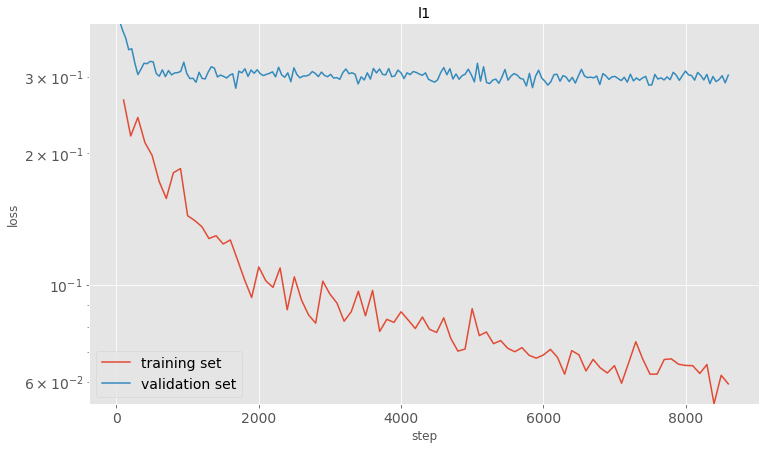

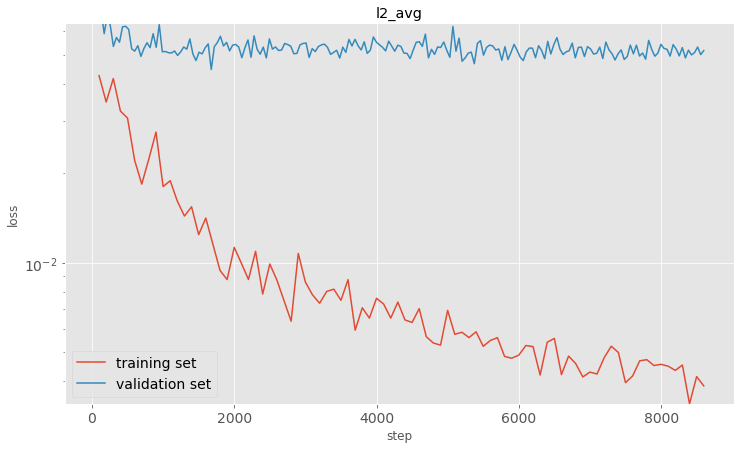

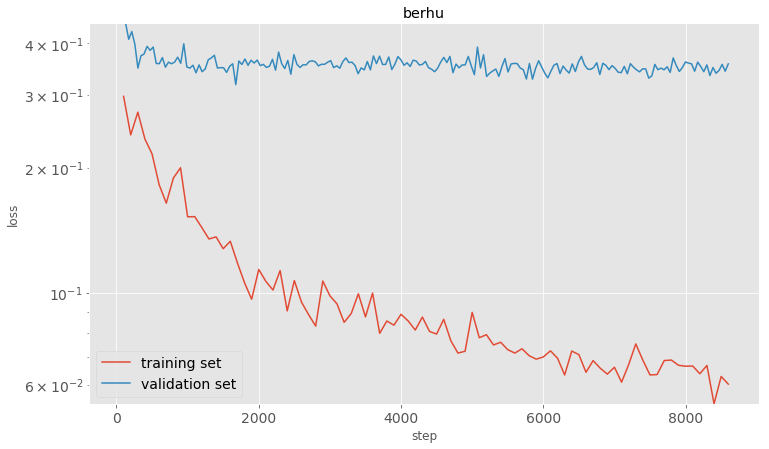

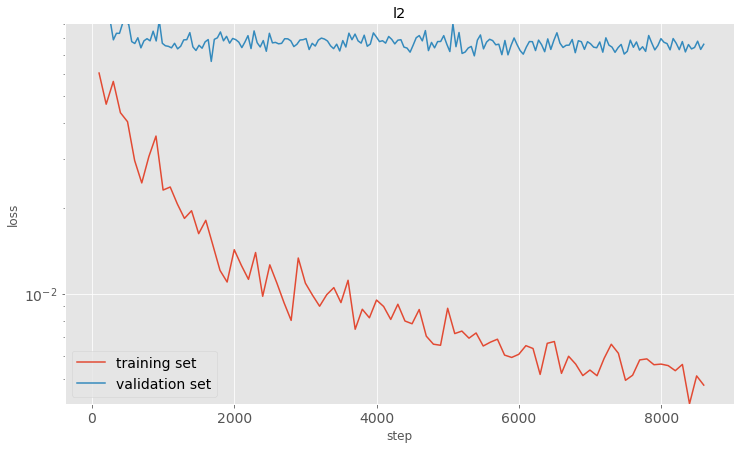

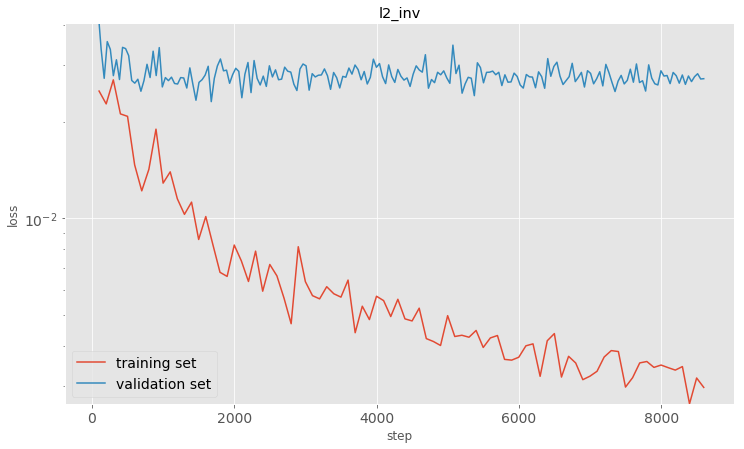

In [18]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_narihira2015')
dfs_train_vgg16_narihira2015, dfs_valid_vgg16_narihira2015 = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015,
                 dfdict_valid=dfs_valid_vgg16_narihira2015)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015, 
                    dfs_valid=dfs_valid_vgg16_narihira2015, 
                    logy=True, ylim_scale=1.5)

## VGG-16 deconv_decoder (1 scale):

Training loss:
df_l1 (step: 4300): 0.09377 <-> corresponding valid loss: 0.30771 (step: 4300)
df_l2_avg (step: 3900): 0.00939 <-> corresponding valid loss: 0.05281 (step: 3913)
df_berhu (step: 4200): 0.09723 <-> corresponding valid loss: 0.36274 (step: 4214)
df_l2 (step: 3900): 0.01164 <-> corresponding valid loss: 0.07764 (step: 3913)
df_l2_inv (step: 3900): 0.00714 <-> corresponding valid loss: 0.02797 (step: 3913)

Validation loss:
df_l1 (step: 3956): 0.29708 <-> corresponding train loss: 0.09580 (step: 4000)
df_l2_avg (step: 3999): 0.05010 <-> corresponding train loss: 0.00954 (step: 4000)
df_berhu (step: 3655): 0.33850 <-> corresponding train loss: 0.10222 (step: 3700)
df_l2 (step: 3956): 0.07398 <-> corresponding train loss: 0.01184 (step: 4000)
df_l2_inv (step: 2193): 0.02521 <-> corresponding train loss: 0.01024 (step: 2200)


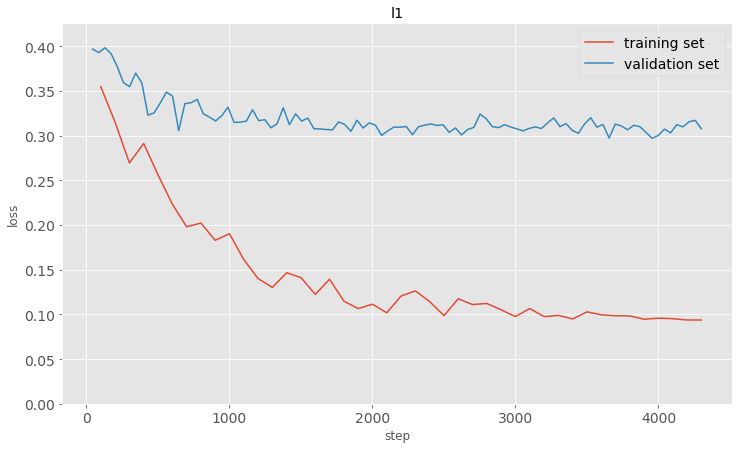

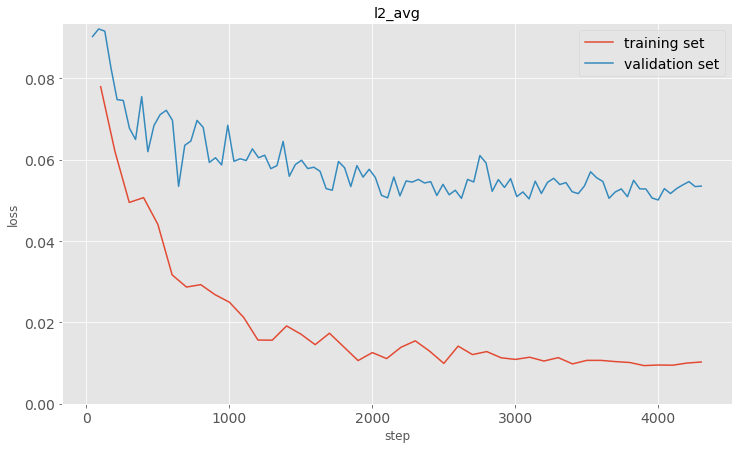

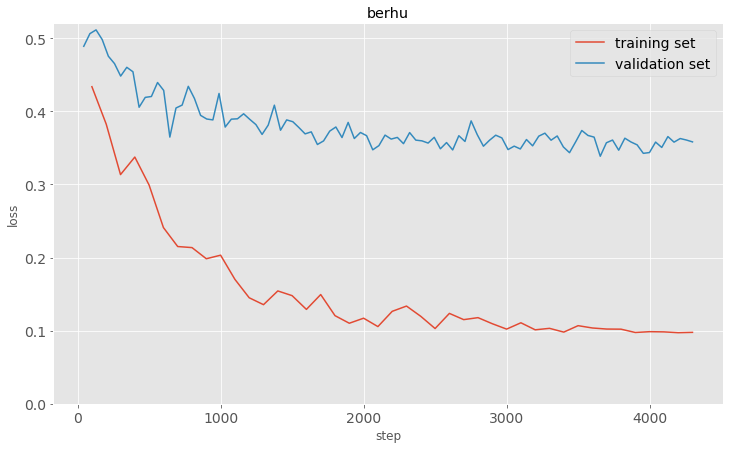

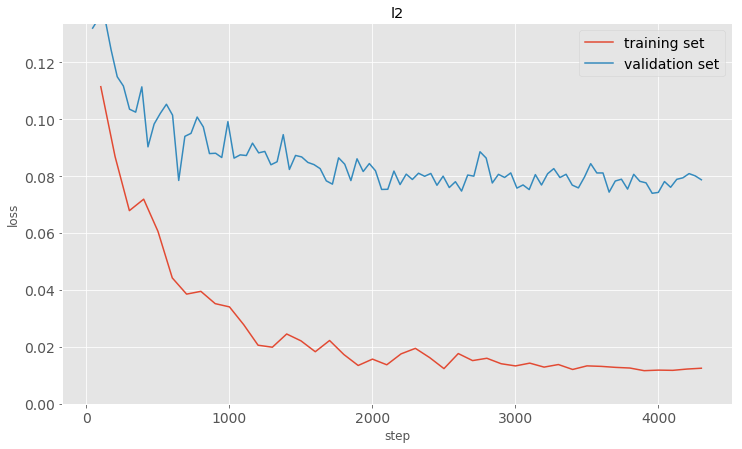

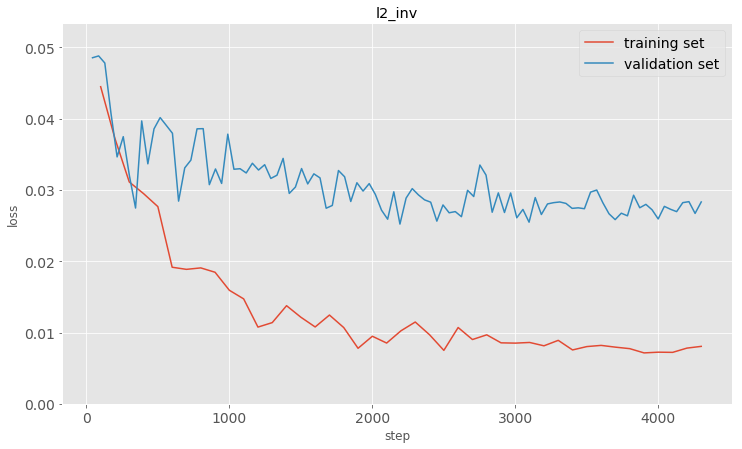

In [19]:
lst = get_all_loss_model_data(data_dir=logs_data_path_sintel + 'slim_vgg16_deconv_decoder')
dfs_train_vgg16_deconv_decoder, dfs_valid_vgg16_deconv_decoder = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_deconv_decoder,
                 dfdict_valid=dfs_valid_vgg16_deconv_decoder)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_deconv_decoder, 
                    dfs_valid=dfs_valid_vgg16_deconv_decoder, 
                    logy=False, ylim_scale=1.2)

# IIW

In [46]:
logs_data_path_iiw = logs_data_path + 'iiw/'

## Resnet-50 narihira2015 (2 scale, reduced parameters):
### lambda = 1.0 (mhdl) (based on deleted sintel model)

Training loss:
df_l2_mhdl (step: 9200): 0.76194 <-> corresponding valid loss: 0.88065 (step: 9136)
df_mwhdl (step: 9100): 0.49050 <-> corresponding valid loss: 0.61459 (step: 9136)
df_l2 (step: 7700): 0.00223 <-> corresponding valid loss: 0.00881 (step: 7672)
df_l1_mwhdl (step: 9100): 0.52798 <-> corresponding valid loss: 0.65647 (step: 9136)
df_l1_mhdl (step: 9200): 0.79556 <-> corresponding valid loss: 0.91885 (step: 9136)
df_l1 (step: 7700): 0.03112 <-> corresponding valid loss: 0.06270 (step: 7672)
df_mhdl (step: 9200): 0.75899 <-> corresponding valid loss: 0.87698 (step: 9136)
df_l2_mwhdl (step: 9100): 0.49345 <-> corresponding valid loss: 0.61826 (step: 9136)

Validation loss:
df_l2_mhdl (step: 9136): 0.88065 <-> corresponding train loss: 0.78101 (step: 9100)
df_mwhdl (step: 8648): 0.61422 <-> corresponding train loss: 0.54578 (step: 8600)
df_l2 (step: 9136): 0.00367 <-> corresponding train loss: 0.00295 (step: 9100)
df_l1_mwhdl (step: 9136): 0.65647 <-> corresponding train loss:

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


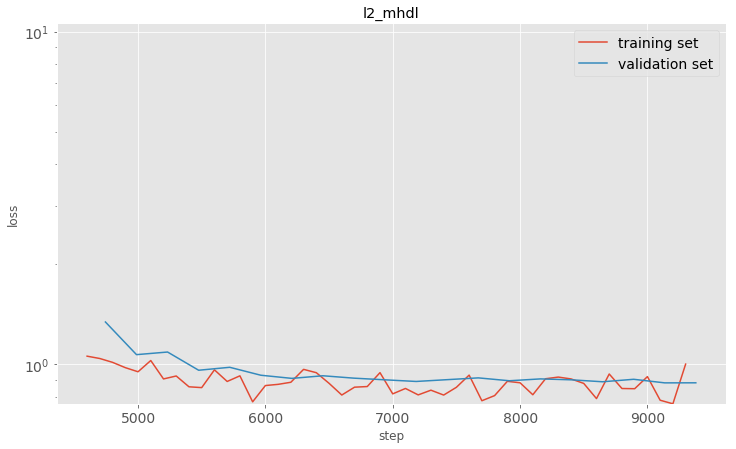

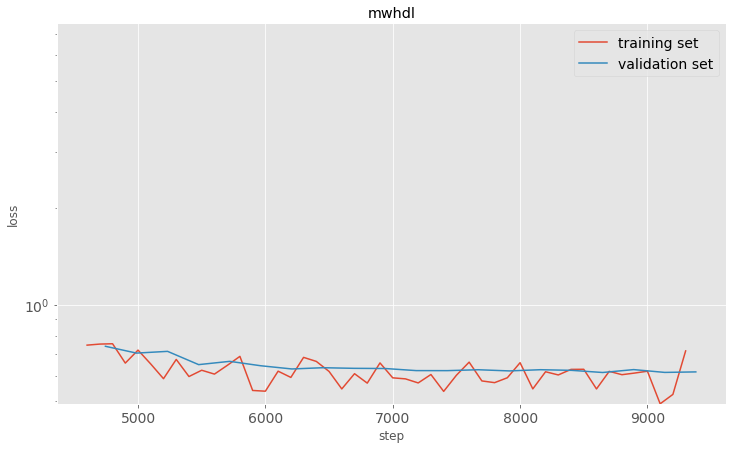

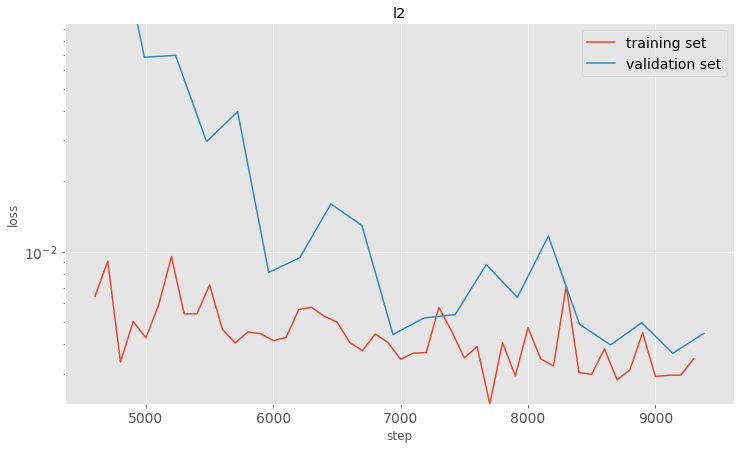

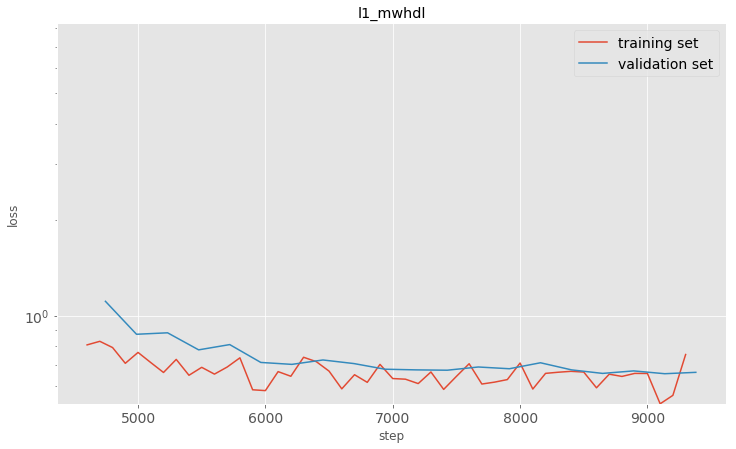

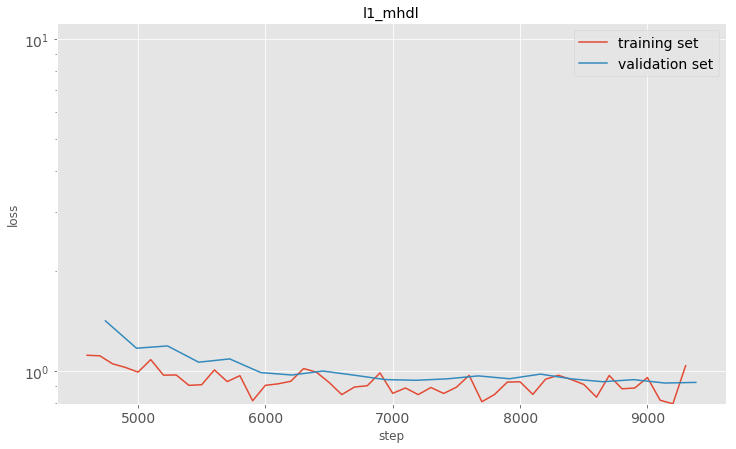

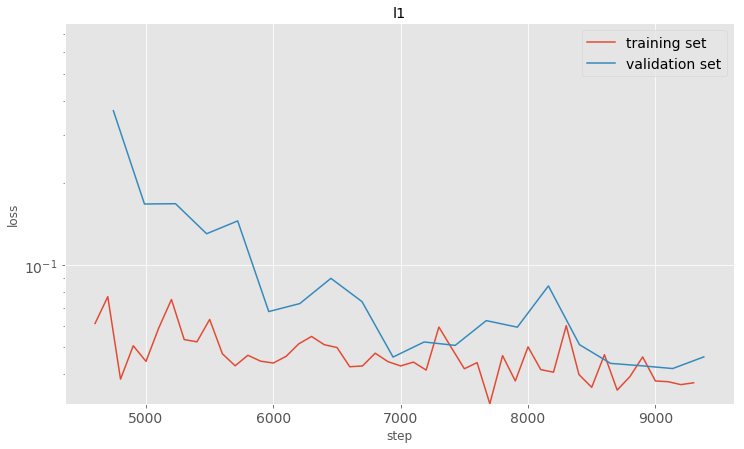

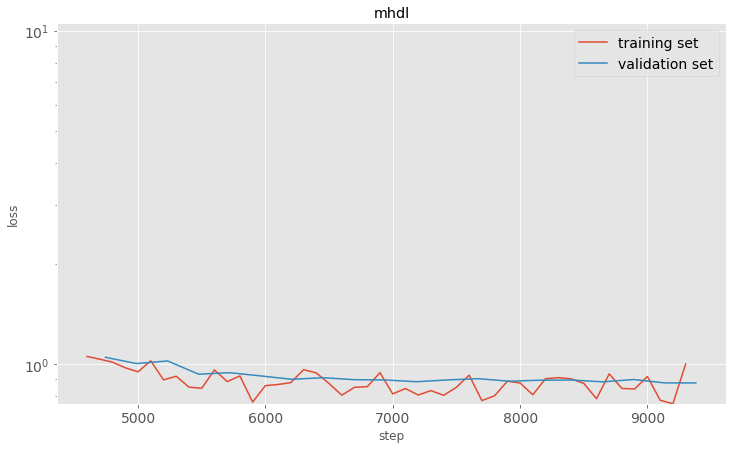

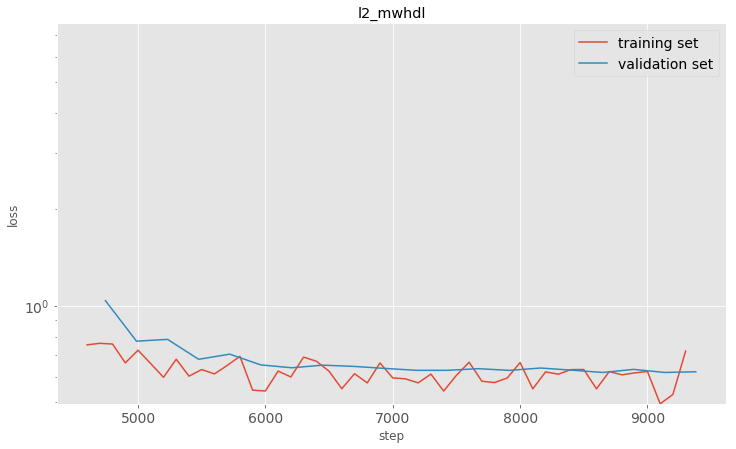

In [47]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_10mhdl'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_iiw, dfs_valid_iiw = lst

df_minloss_iiw_l1mhdl_l10 = get_minimum_loss(dfdict_train=dfs_train_iiw,
                                         dfdict_valid=dfs_valid_iiw)
df_minloss_iiw_l1mhdl_l10[('training', 'step_file')] = ('tfmodel-' + df_minloss_iiw_l1mhdl_l10[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mhdl_l10[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_iiw_l1mhdl_l10[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mhdl_l10.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=True, ylim_scale=10)

### lambda = 0.01 (mwhdl) (based on sintel model 4300) norm l2

Training loss:
df_mwhdl (step: 9100): 0.69091 <-> corresponding valid loss: 0.73363 (step: 9140)
df_l2_mhdl (step: 8900): 0.01205 <-> corresponding valid loss: 0.01314 (step: 8896)
df_l2_mwhdl (step: 9100): 0.00867 <-> corresponding valid loss: 0.00912 (step: 9140)
df_l1_mwhdl (step: 9100): 0.03381 <-> corresponding valid loss: 0.03480 (step: 9140)
df_l1_mhdl (step: 8000): 0.03726 <-> corresponding valid loss: 0.04537 (step: 7920)
df_l1 (step: 8000): 0.02679 <-> corresponding valid loss: 0.03489 (step: 7920)
df_mhdl (step: 7600): 1.02659 <-> corresponding valid loss: 1.04944 (step: 7676)
df_l2 (step: 8000): 0.00167 <-> corresponding valid loss: 0.00289 (step: 7920)

Validation loss:
df_mwhdl (step: 9140): 0.73363 <-> corresponding train loss: 0.69091 (step: 9100)
df_l2_mhdl (step: 9140): 0.01214 <-> corresponding train loss: 0.01219 (step: 9100)
df_l2_mwhdl (step: 9140): 0.00912 <-> corresponding train loss: 0.00867 (step: 9100)
df_l1_mwhdl (step: 8408): 0.03404 <-> corresponding train

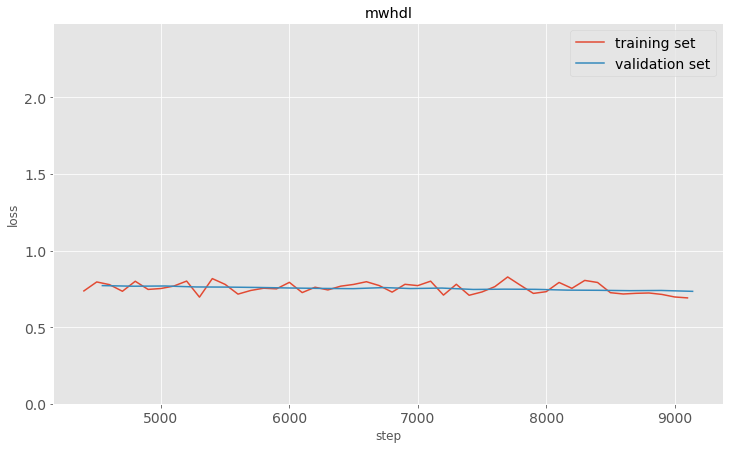

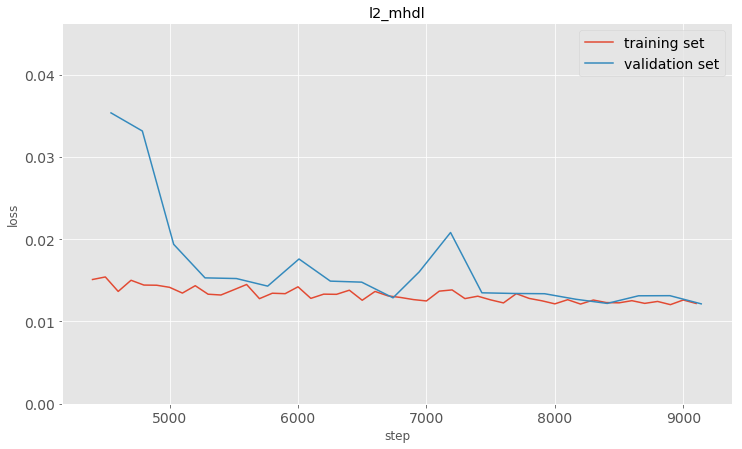

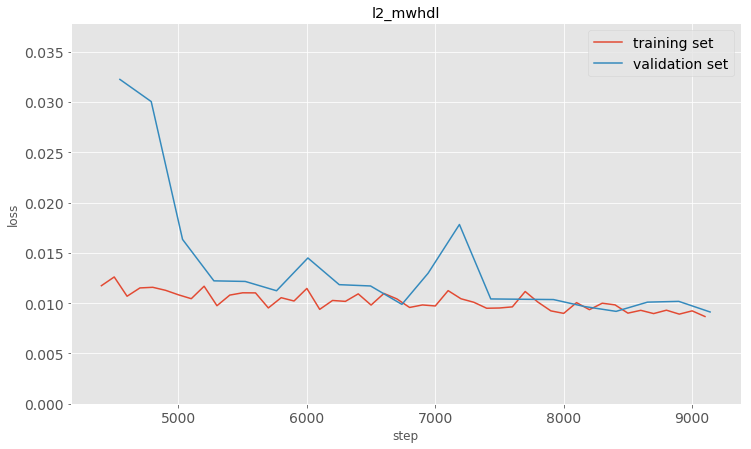

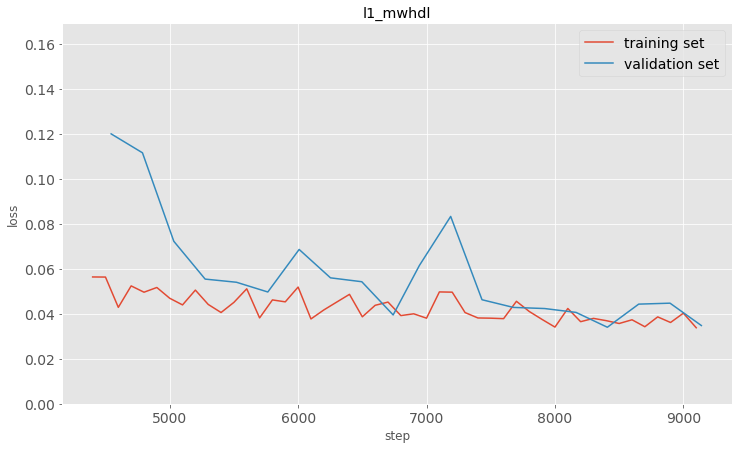

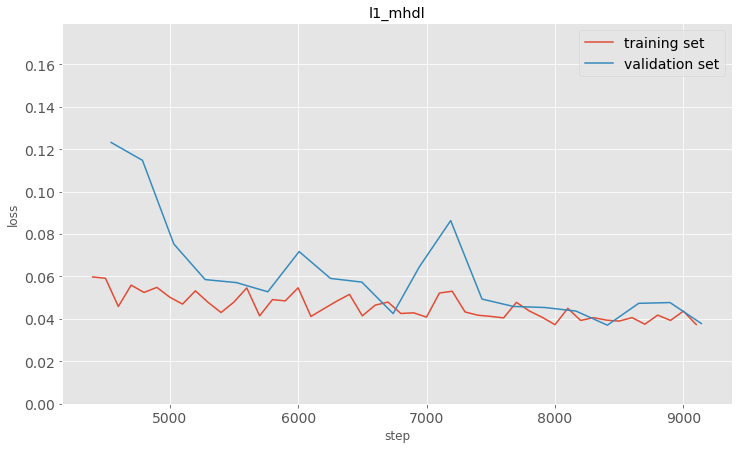

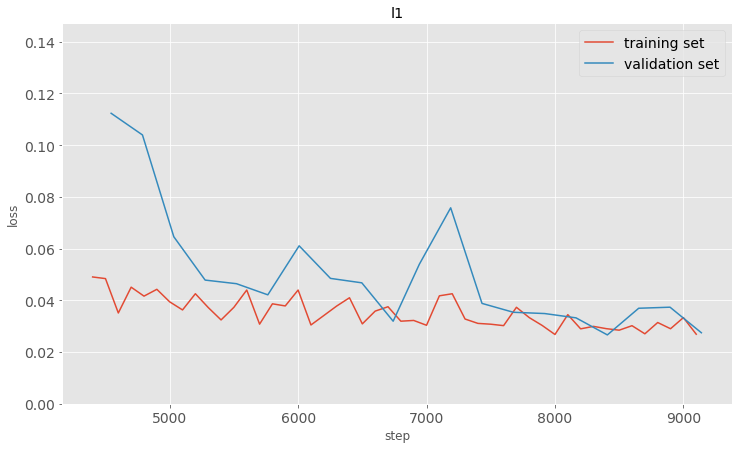

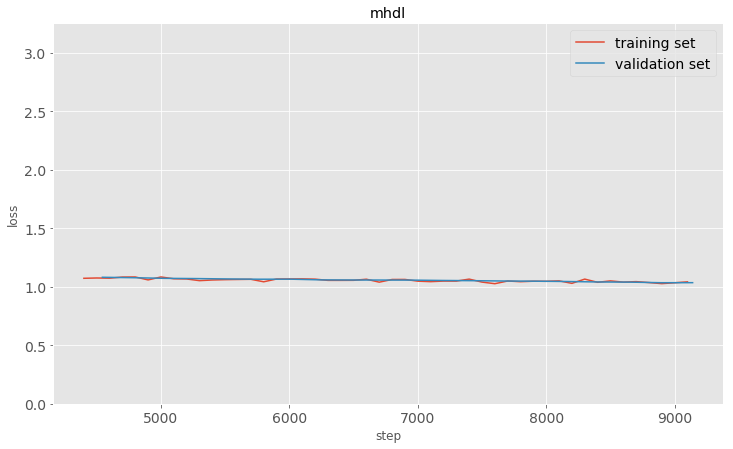

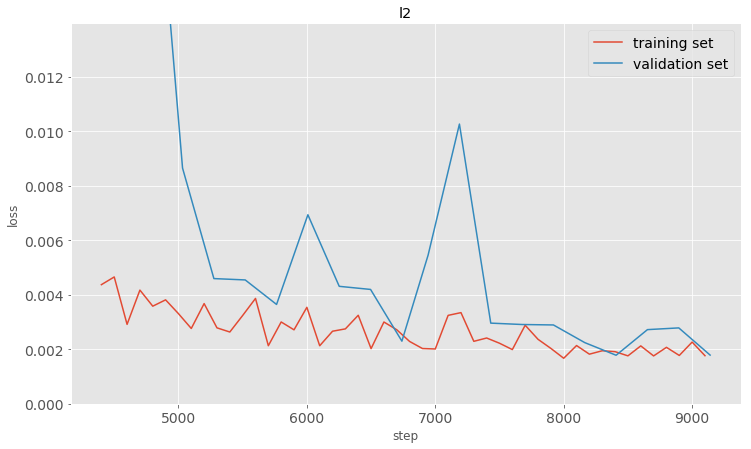

In [48]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l2_001mwhdl'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_iiw, dfs_valid_iiw = lst

df_minloss_iiw_l2mwhdl_l001 = get_minimum_loss(dfdict_train=dfs_train_iiw,
                                               dfdict_valid=dfs_valid_iiw)
df_minloss_iiw_l2mwhdl_l001[('training', 'step_file')] = ('tfmodel-' + df_minloss_iiw_l2mwhdl_l001[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l2mwhdl_l001[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_iiw_l2mwhdl_l001[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l2mwhdl_l001.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=False, ylim_scale=3)

### lambda = 0.05 (mwhdl) (based on sintel model 4300)

Training loss:
df_mwhdl (step: 8100): 0.64828 <-> corresponding valid loss: 0.75128 (step: 8164)
df_l2_mhdl (step: 7000): 0.01229 <-> corresponding valid loss: 0.01504 (step: 6944)
df_l2 (step: 7000): 0.00176 <-> corresponding valid loss: 0.00442 (step: 6944)
df_l1_mwhdl (step: 8800): 0.03563 <-> corresponding valid loss: 0.04238 (step: 8896)
df_l1_mhdl (step: 8300): 0.03881 <-> corresponding valid loss: 0.05193 (step: 8408)
df_l1 (step: 8300): 0.02833 <-> corresponding valid loss: 0.04142 (step: 8408)
df_mhdl (step: 8600): 1.04030 <-> corresponding valid loss: 1.04889 (step: 8652)
df_l2_mwhdl (step: 8100): 0.00876 <-> corresponding valid loss: 0.01077 (step: 8164)

Validation loss:
df_mwhdl (step: 8652): 0.74561 <-> corresponding train loss: 0.76373 (step: 8700)
df_l2_mhdl (step: 8896): 0.01313 <-> corresponding train loss: 0.01288 (step: 8900)
df_l2 (step: 7920): 0.00264 <-> corresponding train loss: 0.00250 (step: 7900)
df_l1_mwhdl (step: 8896): 0.04238 <-> corresponding train loss:

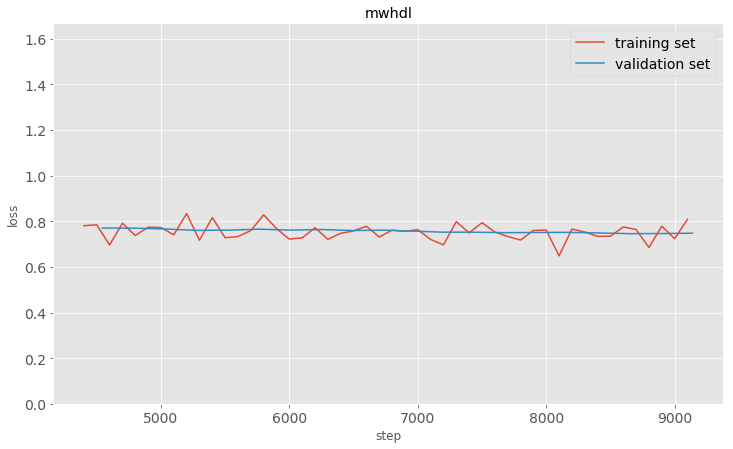

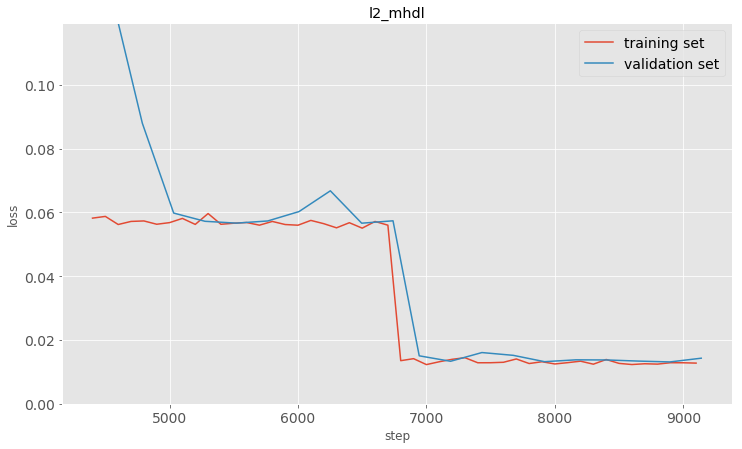

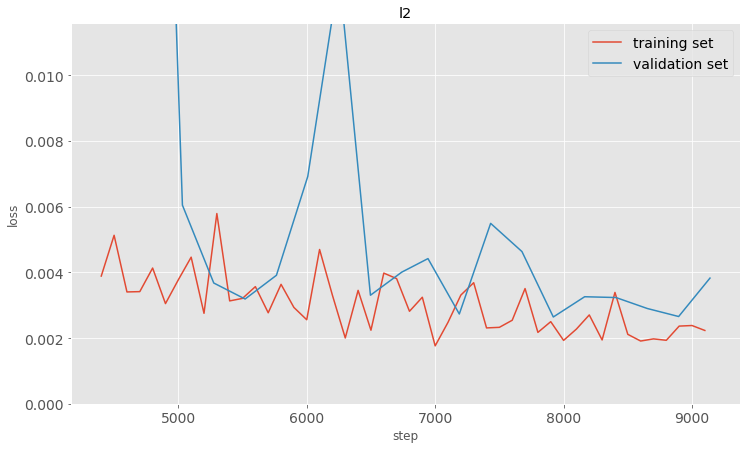

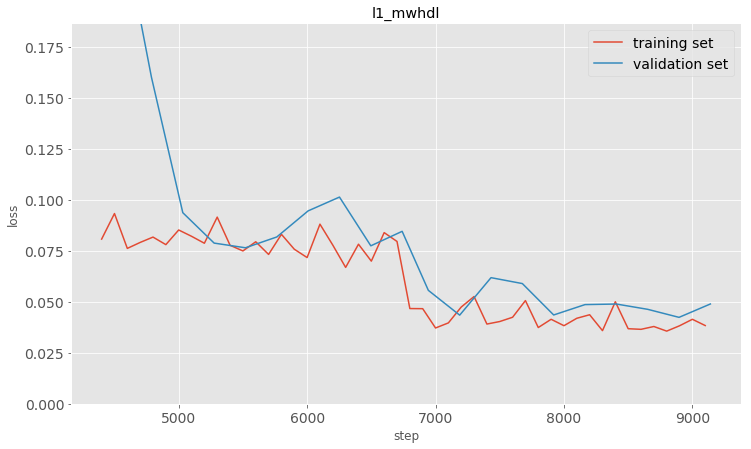

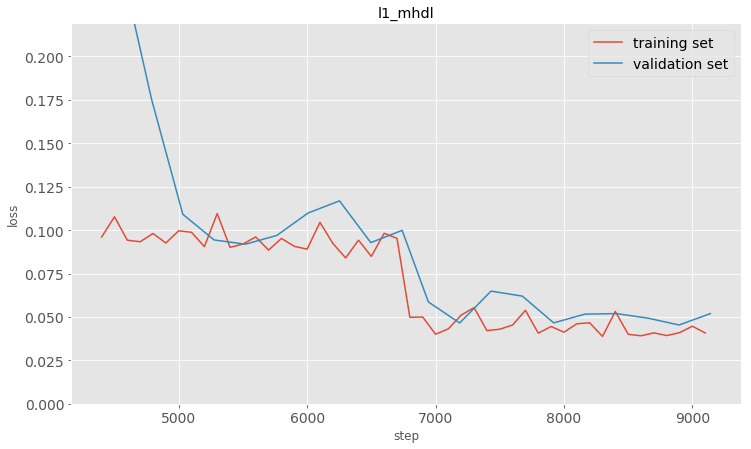

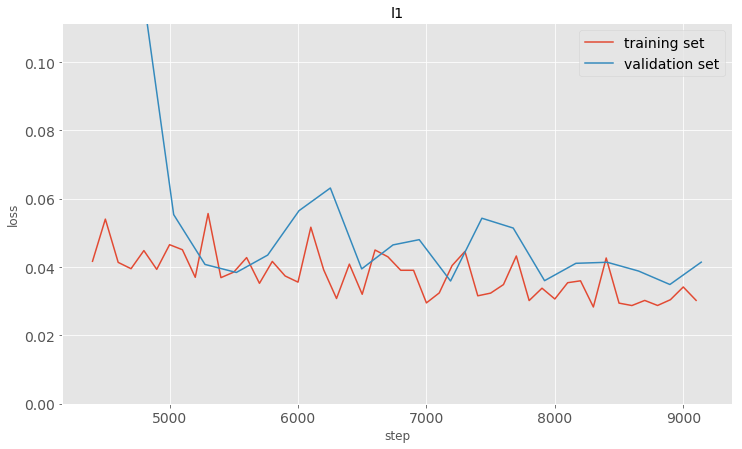

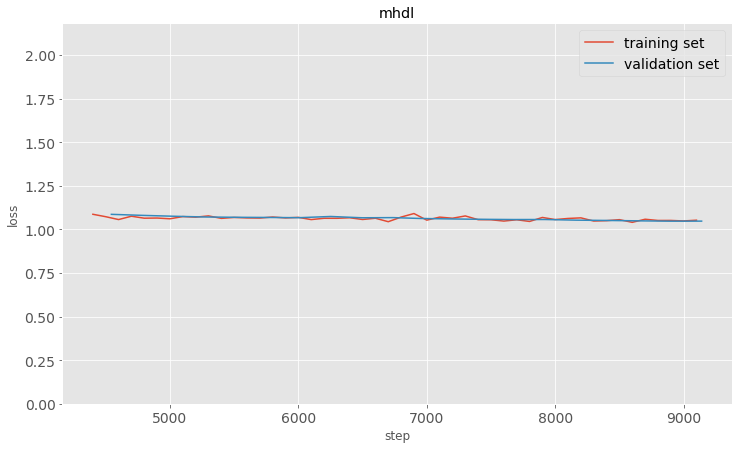

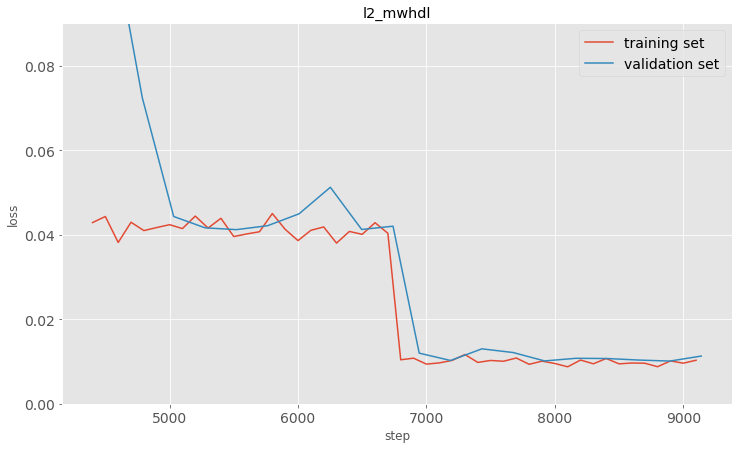

In [49]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_005mwhdl'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_iiw, dfs_valid_iiw = lst

df_minloss_iiw_l1mwhdl_l005 = get_minimum_loss(dfdict_train=dfs_train_iiw,
                                               dfdict_valid=dfs_valid_iiw)
df_minloss_iiw_l1mwhdl_l005[('training', 'step_file')] = ('tfmodel-' + df_minloss_iiw_l1mwhdl_l005[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mwhdl_l005[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_iiw_l1mwhdl_l005[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mwhdl_l005.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=False, ylim_scale=2)

### lambda = 0.1 (mhdl) (based on sintel model 4300)

Training loss:
df_l2_mhdl (step: 5400): 0.10606 <-> corresponding valid loss: 0.11128 (step: 5520)
df_mwhdl (step: 4500): 0.62540 <-> corresponding valid loss: 0.76414 (step: 4544)
df_l2 (step: 6400): 0.00221 <-> corresponding valid loss: 0.00822 (step: 6496)
df_l1_mwhdl (step: 5400): 0.10426 <-> corresponding valid loss: 0.12621 (step: 5520)
df_l1_mhdl (step: 6400): 0.13472 <-> corresponding valid loss: 0.16879 (step: 6496)
df_l1 (step: 6400): 0.03051 <-> corresponding valid loss: 0.06458 (step: 6496)
df_mhdl (step: 6300): 1.03650 <-> corresponding valid loss: 1.04492 (step: 6252)
df_l2_mwhdl (step: 4500): 0.06874 <-> corresponding valid loss: 0.17397 (step: 4544)

Validation loss:
df_l2_mhdl (step: 6252): 0.10735 <-> corresponding train loss: 0.10709 (step: 6300)
df_mwhdl (step: 6496): 0.73807 <-> corresponding train loss: 0.70676 (step: 6500)
df_l2 (step: 6252): 0.00286 <-> corresponding train loss: 0.00344 (step: 6300)
df_l1_mwhdl (step: 6252): 0.10989 <-> corresponding train loss:

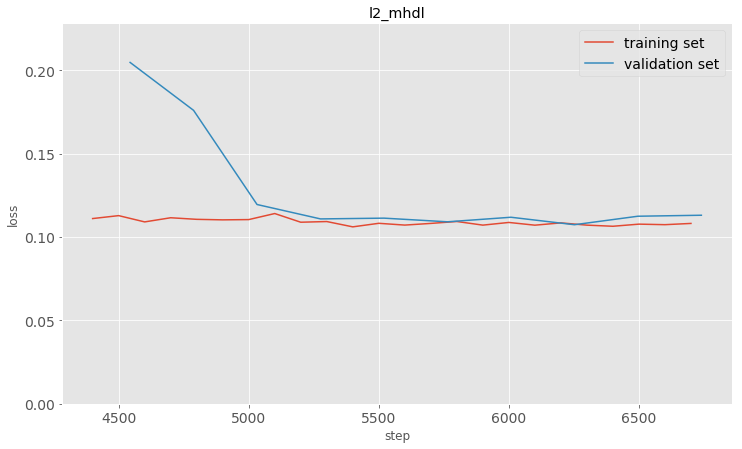

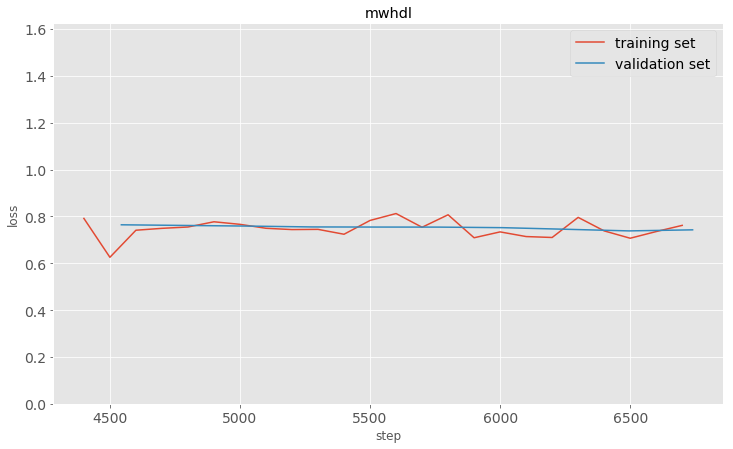

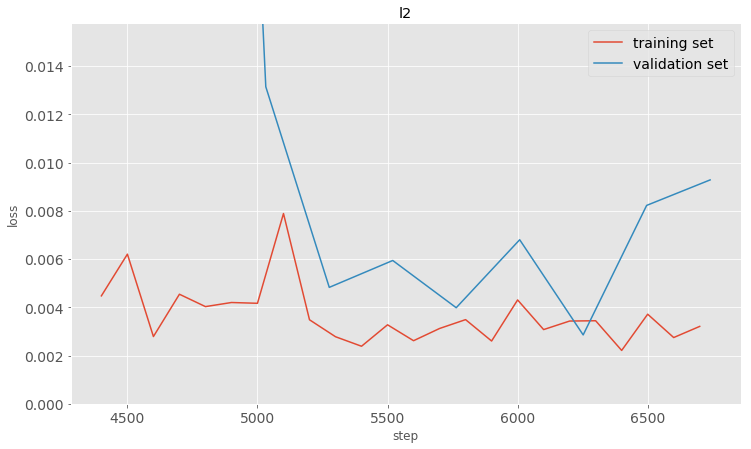

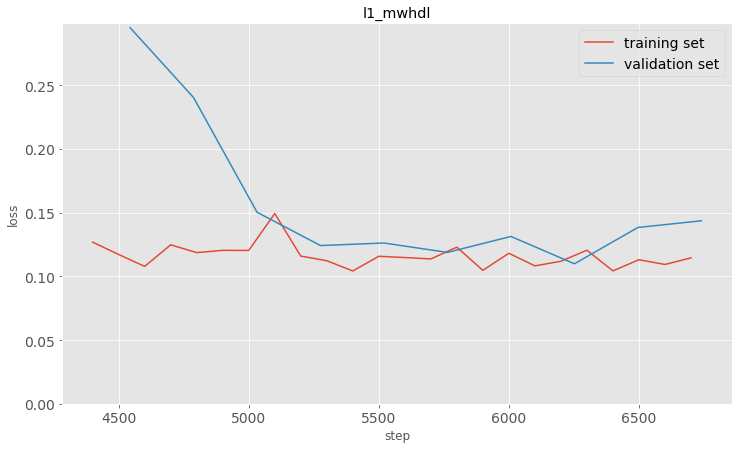

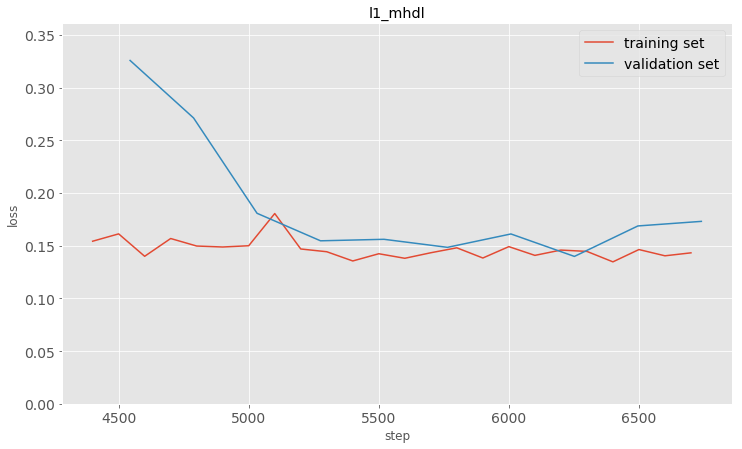

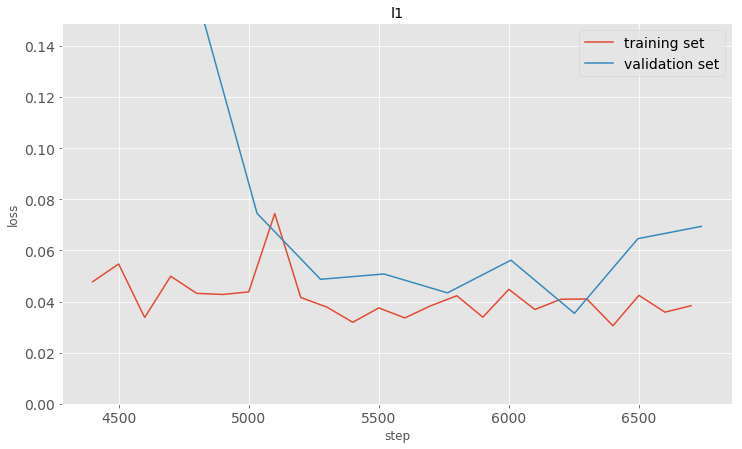

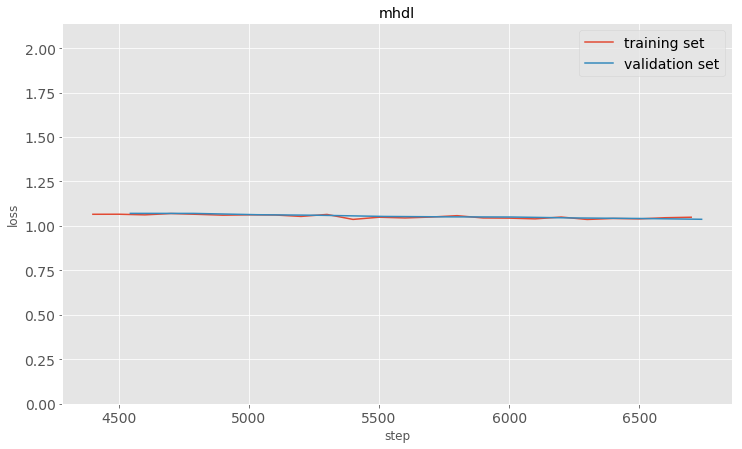

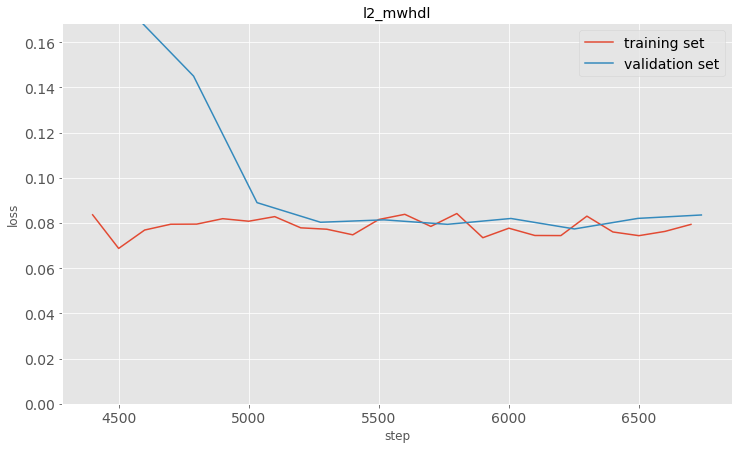

In [50]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mhdl'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_iiw, dfs_valid_iiw = lst

df_minloss_iiw_l1mhdl_l01 = get_minimum_loss(dfdict_train=dfs_train_iiw,
                                             dfdict_valid=dfs_valid_iiw)
df_minloss_iiw_l1mhdl_l01[('training', 'step_file')] = ('tfmodel-' + df_minloss_iiw_l1mhdl_l01[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mhdl_l01[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_iiw_l1mhdl_l01[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mhdl_l01.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=False, ylim_scale=2)

### lambda = 0.1 (mwhdl) (based on sintel model 4300)

Training loss:
df_l2_mhdl (step: 9100): 0.10202 <-> corresponding valid loss: 0.10737 (step: 9140)
df_mwhdl (step: 6800): 0.66469 <-> corresponding valid loss: 0.74470 (step: 6740)
df_l2 (step: 9000): 0.00201 <-> corresponding valid loss: 0.00361 (step: 8896)
df_l1_mwhdl (step: 8300): 0.10007 <-> corresponding valid loss: 0.14699 (step: 8408)
df_l1_mhdl (step: 8600): 0.13068 <-> corresponding valid loss: 0.14061 (step: 8652)
df_l1 (step: 8600): 0.02824 <-> corresponding valid loss: 0.03733 (step: 8652)
df_mhdl (step: 9100): 0.99853 <-> corresponding valid loss: 1.02938 (step: 9140)
df_l2_mwhdl (step: 6800): 0.06969 <-> corresponding valid loss: 0.07810 (step: 6740)

Validation loss:
df_l2_mhdl (step: 8652): 0.10621 <-> corresponding train loss: 0.10449 (step: 8700)
df_mwhdl (step: 8896): 0.73227 <-> corresponding train loss: 0.73995 (step: 8900)
df_l2 (step: 8652): 0.00293 <-> corresponding train loss: 0.00293 (step: 8700)
df_l1_mwhdl (step: 8652): 0.11108 <-> corresponding train loss:

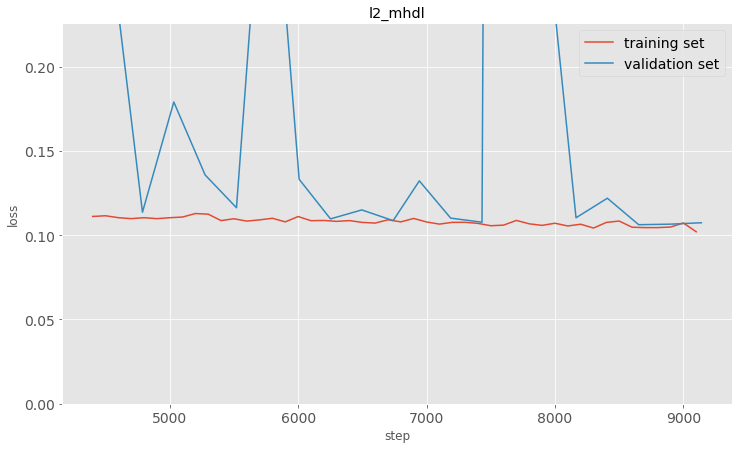

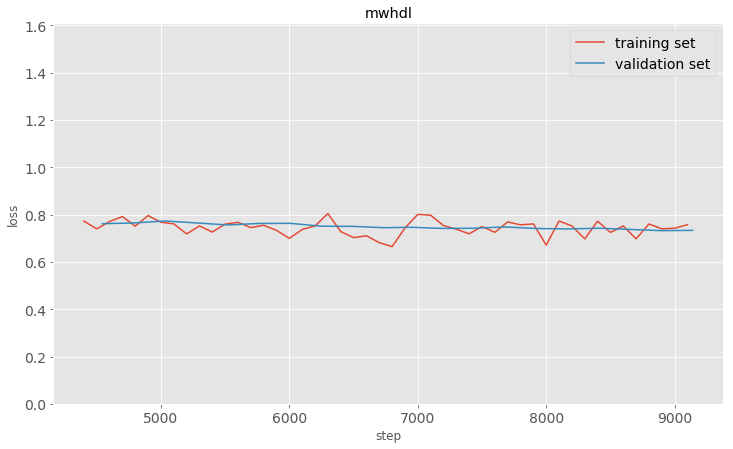

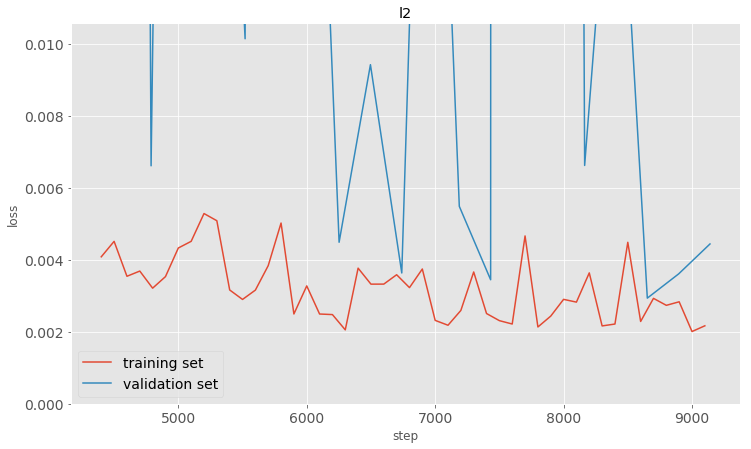

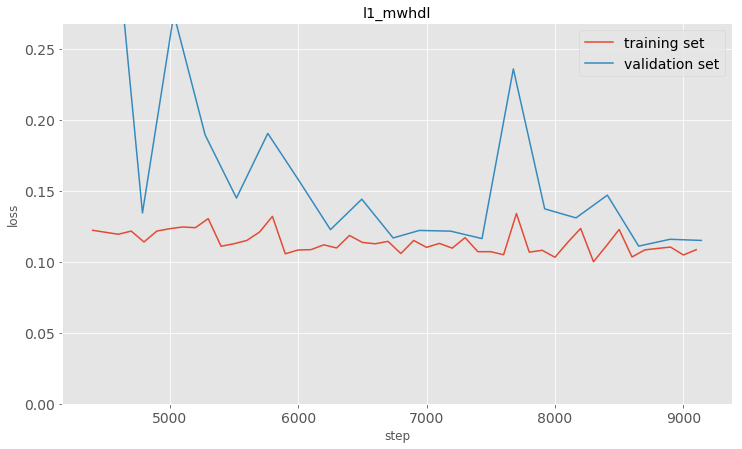

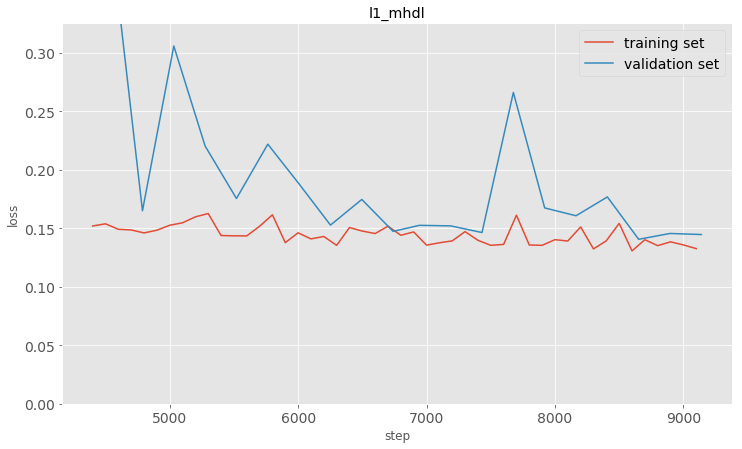

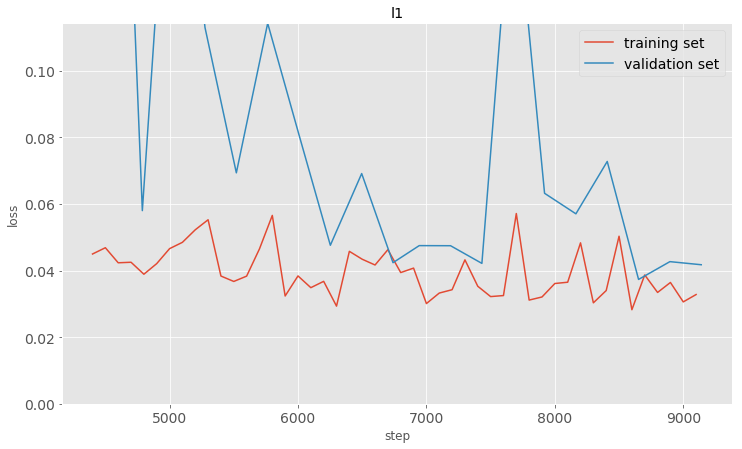

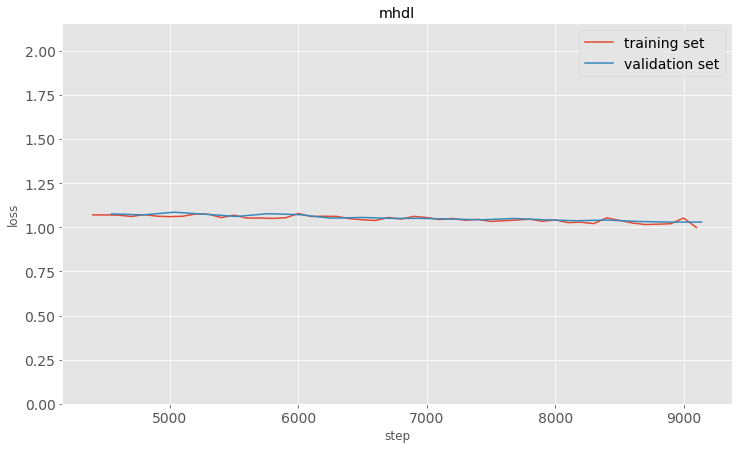

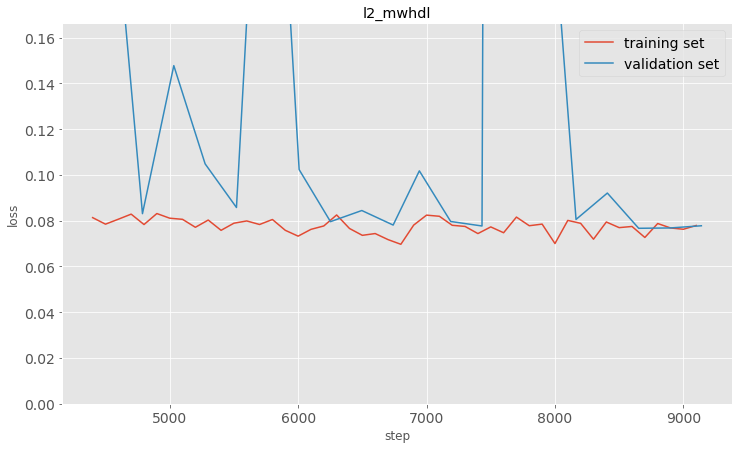

In [51]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_narihira2015_reduced/norm_l1_01mwhdl'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_iiw, dfs_valid_iiw = lst

df_minloss_iiw_l1mwhdl_l01 = get_minimum_loss(dfdict_train=dfs_train_iiw,
                                              dfdict_valid=dfs_valid_iiw)
df_minloss_iiw_l1mwhdl_l01[('training', 'step_file')] = ('tfmodel-' + df_minloss_iiw_l1mwhdl_l01[('training', 'step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mwhdl_l01[('validation', 'cor_val_tr_step_file')] = ('tfmodel-' + df_minloss_iiw_l1mwhdl_l01[('validation', 'cor_val_tr_step')].astype(str) + '.meta').apply(lambda x: find_file(name=x, path=filepath.replace('logs_data/', '')))
df_minloss_iiw_l1mwhdl_l01.sort_index(axis=1, level=0, inplace=True)

plot_all_loss_pairs(dfs_train=dfs_train_iiw, 
                    dfs_valid=dfs_valid_iiw, 
                    logy=False, ylim_scale=2)

In [52]:
df_minloss_iiw_l1mhdl_l01['model'] = 'resnet_narihira_l1mhdl_l01'
df_minloss_iiw_l1mhdl_l01.set_index('model', append=True, inplace=True)

df_minloss_iiw_l1mhdl_l10['model'] = 'resnet_narihira_l1mhdl_l10'
df_minloss_iiw_l1mhdl_l10.set_index('model', append=True, inplace=True)
df_iiw_analysis = df_minloss_iiw_l1mhdl_l01.append(df_minloss_iiw_l1mhdl_l10)

df_minloss_iiw_l1mwhdl_l005['model'] = 'resnet_narihira_l1mwhdl_l005'
df_minloss_iiw_l1mwhdl_l005.set_index('model', append=True, inplace=True)
df_iiw_analysis = df_iiw_analysis.append(df_minloss_iiw_l1mwhdl_l005)

df_minloss_iiw_l1mwhdl_l01['model'] = 'resnet_narihira_l1mwhdl_l01'
df_minloss_iiw_l1mwhdl_l01.set_index('model', append=True, inplace=True)
df_iiw_analysis = df_iiw_analysis.append(df_minloss_iiw_l1mwhdl_l01)

df_minloss_iiw_l2mwhdl_l001['model'] = 'resnet_narihira_l2mwhdl_l001'
df_minloss_iiw_l2mwhdl_l001.set_index('model', append=True, inplace=True)
df_iiw_analysis = df_iiw_analysis.append(df_minloss_iiw_l2mwhdl_l001)

df_iiw_analysis.sort_index(inplace=True)
df_iiw_analysis.index.names = ['loss_type', 'model']
df_iiw_analysis.to_pickle(path='figures/df_iiw_loss_analysis.pkl')

In [53]:
df_iiw_analysis

training                  \
                                         cor_val_tr_loss cor_val_tr_step   
loss_type   model                                                          
df_l1       resnet_narihira_l1mhdl_l01          0.064575            6496   
            resnet_narihira_l1mhdl_l10          0.062696            7672   
            resnet_narihira_l1mwhdl_l005        0.041422            8408   
            resnet_narihira_l1mwhdl_l01         0.037330            8652   
            resnet_narihira_l2mwhdl_l001        0.034889            7920   
df_l1_mhdl  resnet_narihira_l1mhdl_l01          0.168786            6496   
            resnet_narihira_l1mhdl_l10          0.918854            9136   
            resnet_narihira_l1mwhdl_l005        0.051932            8408   
            resnet_narihira_l1mwhdl_l01         0.140610            8652   
            resnet_narihira_l2mwhdl_l001        0.045369            7920   
df_l1_mwhdl resnet_narihira_l1mhdl_l01          0.126213            5520   
            resnet_narihira_l1mhdl_l10          0.656467            9136   
            resnet_narihira_l1mwhdl_l005        0.042376            8896   
            resnet_narihira_l1mwhdl_l01         0.146987            8408   
            resnet_narihira_l2mwhdl_l001        0.034798            9140   
df_l2       resnet_narihira_l1mhdl_l01          0.008222            6496   
            resnet_narihira_l1mhdl_l10          0.008810            7672   
            resnet_narihira_l1mwhdl_l005        0.004419            6944   
            resnet_narihira_l1mwhdl_l01         0.003606            8896   
            resnet_narihira_l2mwhdl_l001        0.002894            7920   
df_l2_mhdl  resnet_narihira_l1mhdl_l01          0.111285            5520   
            resnet_narihira_l1mhdl_l10          0.880646            9136   
            resnet_narihira_l1mwhdl_l005        0.015045            6944   
            resnet_narihira_l1mwhdl_l01         0.107375            9140   
            resnet_narihira_l2mwhdl_l001        0.013136            8896   
df_l2_mwhdl resnet_narihira_l1mhdl_l01          0.173970            4544   
            resnet_narihira_l1mhdl_l10          0.618258            9136   
            resnet_narihira_l1mwhdl_l005        0.010772            8164   
            resnet_narihira_l1mwhdl_l01         0.078102            6740   
            resnet_narihira_l2mwhdl_l001        0.009124            9140   
df_mhdl     resnet_narihira_l1mhdl_l01          1.044918            6252   
            resnet_narihira_l1mhdl_l10          0.876980            9136   
            resnet_narihira_l1mwhdl_l005        1.048890            8652   
            resnet_narihira_l1mwhdl_l01         1.029377            9140   
            resnet_narihira_l2mwhdl_l001        1.049440            7676   
df_mwhdl    resnet_narihira_l1mhdl_l01          0.764136            4544   
            resnet_narihira_l1mhdl_l10          0.614593            9136   
            resnet_narihira_l1mwhdl_l005        0.751284            8164   
            resnet_narihira_l1mwhdl_l01         0.744703            6740   
            resnet_narihira_l2mwhdl_l001        0.733632            9140   

                                                             \
                                         minimum_loss  step   
loss_type   model                                             
df_l1       resnet_narihira_l1mhdl_l01       0.030512  6400   
            resnet_narihira_l1mhdl_l10       0.031116  7700   
            resnet_narihira_l1mwhdl_l005     0.028333  8300   
            resnet_narihira_l1mwhdl_l01      0.028238  8600   
            resnet_narihira_l2mwhdl_l001     0.026794  8000   
df_l1_mhdl  resnet_narihira_l1mhdl_l01       0.134720  6400   
            resnet_narihira_l1mhdl_l10       0.795560  9200   
            resnet_narihira_l1mwhdl_l005     0.038811  8300   
            resnet_narihira_l1mwhdl_l01      0.130680  8600   
            resnet_nari

## Resnet-50 deconv decoder (1 scale):
### lambda = 0.5 (mhdl)

Training loss:
df_mwhdl (step: 8400): 0.53156 <-> corresponding valid loss: 0.73895 (step: 8496)
df_l2_mhdl (step: 7900): 0.40670 <-> corresponding valid loss: 1.53395 (step: 8008)
df_l2 (step: 7900): 0.00910 <-> corresponding valid loss: 0.98829 (step: 8008)
df_l1_mwhdl (step: 8400): 0.33305 <-> corresponding valid loss: 0.64022 (step: 8496)
df_l1_mhdl (step: 7900): 0.45909 <-> corresponding valid loss: 0.82195 (step: 8008)
df_l1 (step: 7900): 0.06149 <-> corresponding valid loss: 0.27628 (step: 8008)
df_mhdl (step: 7900): 0.79521 <-> corresponding valid loss: 1.09133 (step: 8008)
df_l2_mwhdl (step: 8400): 0.27652 <-> corresponding valid loss: 57.43792 (step: 8496)

Validation loss:
df_mwhdl (step: 8740): 0.63621 <-> corresponding train loss: 0.67074 (step: 8700)
df_l2_mhdl (step: 8252): 0.47555 <-> corresponding train loss: 0.44757 (step: 8300)
df_l2 (step: 8252): 0.02159 <-> corresponding train loss: 0.00964 (step: 8300)
df_l1_mwhdl (step: 8252): 0.42849 <-> corresponding train loss

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


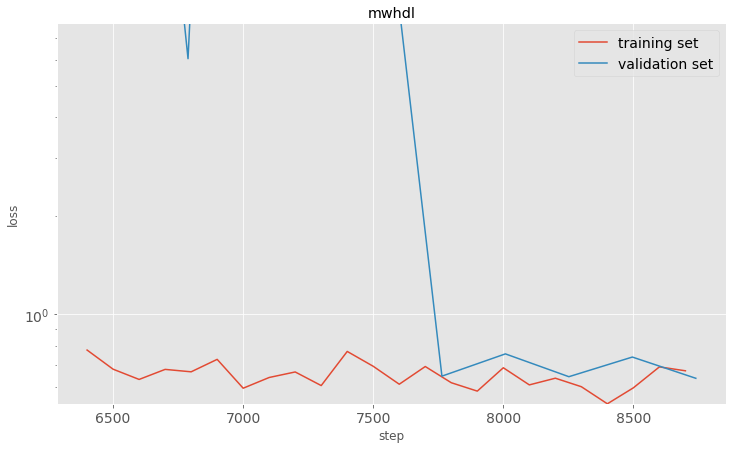

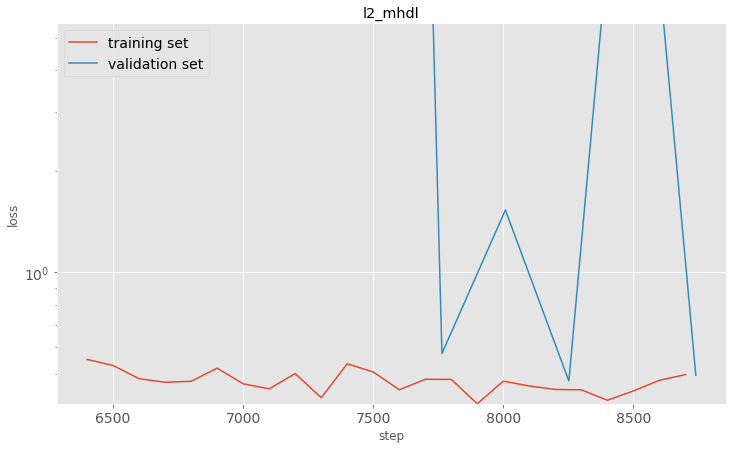

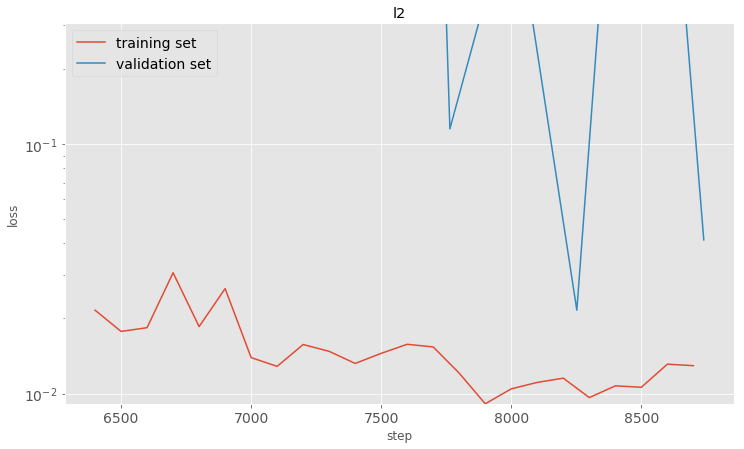

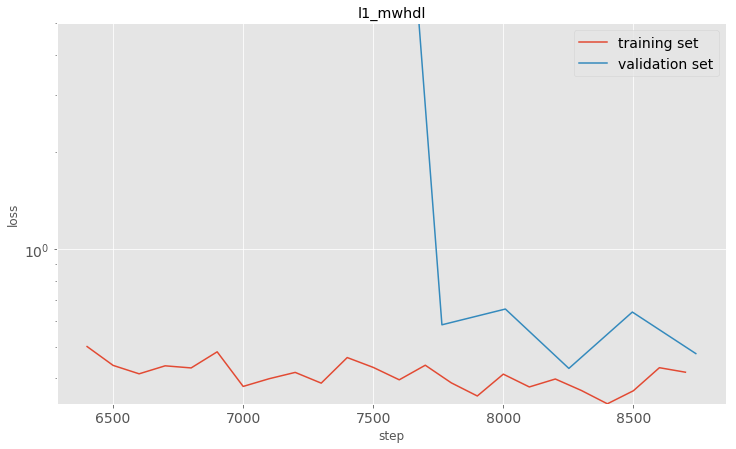

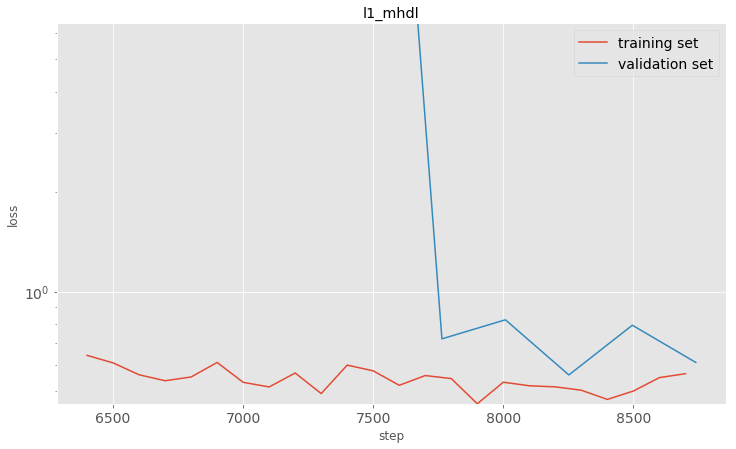

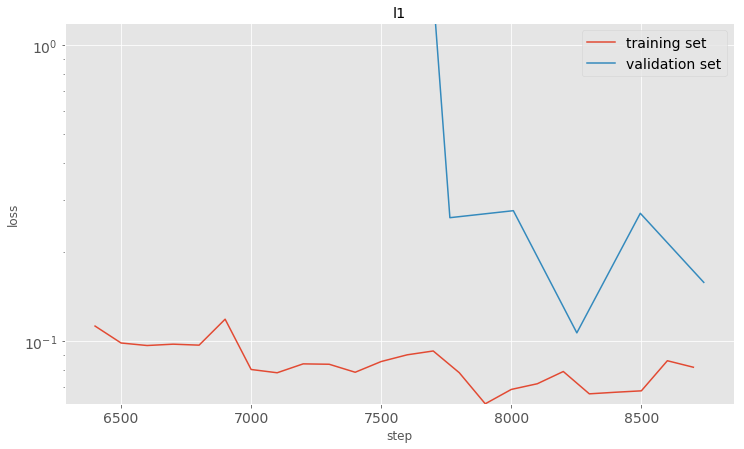

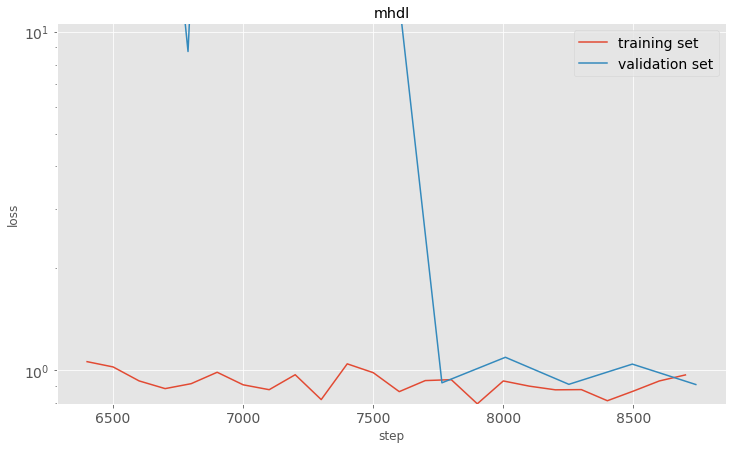

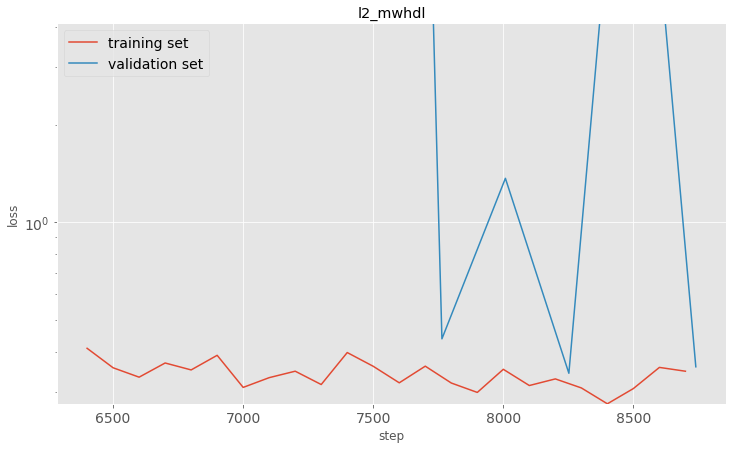

In [27]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_deconv_decoder/l1_05mhdl'
lst = get_all_loss_model_data(data_dir=filepath)
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=True, ylim_scale=10)

### lambda = 1.0 (mhdl)        

Training loss:
df_l1 (step: 8400): 0.05380 <-> corresponding valid loss: 0.07160 (step: 8496)
df_l2 (step: 8400): 0.00715 <-> corresponding valid loss: 0.05235 (step: 8496)
df_mhdl (step: 7700): 0.79028 <-> corresponding valid loss: 0.91040 (step: 7764)
df_l1_mwhdl (step: 8600): 0.60100 <-> corresponding valid loss: 0.69596 (step: 8496)
df_l2_mhdl (step: 7700): 0.80297 <-> corresponding valid loss: 0.93701 (step: 7764)
df_mwhdl (step: 8600): 0.53556 <-> corresponding valid loss: 0.62436 (step: 8496)
df_l1_mhdl (step: 7700): 0.85844 <-> corresponding valid loss: 1.02842 (step: 7764)
df_l2_mwhdl (step: 8600): 0.54650 <-> corresponding valid loss: 0.67670 (step: 8496)

Validation loss:
df_l1 (step: 8496): 0.07160 <-> corresponding train loss: 0.06060 (step: 8500)
df_l2 (step: 8252): 0.01380 <-> corresponding train loss: 0.01601 (step: 8300)
df_mhdl (step: 8496): 0.89498 <-> corresponding train loss: 0.92624 (step: 8500)
df_l1_mwhdl (step: 8496): 0.69596 <-> corresponding train loss: 0.716

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


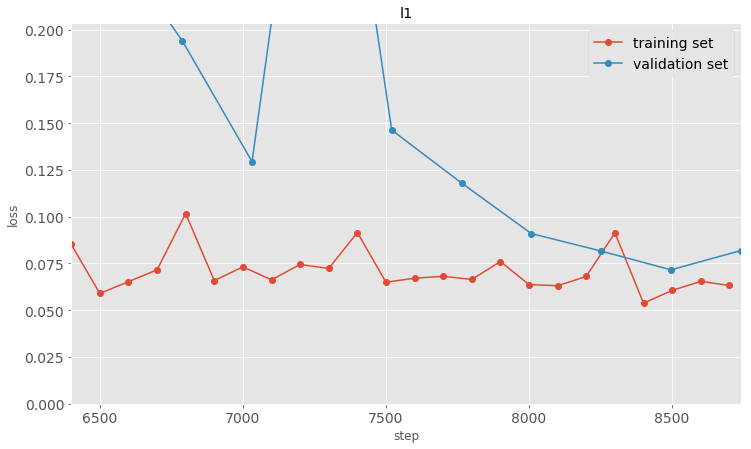

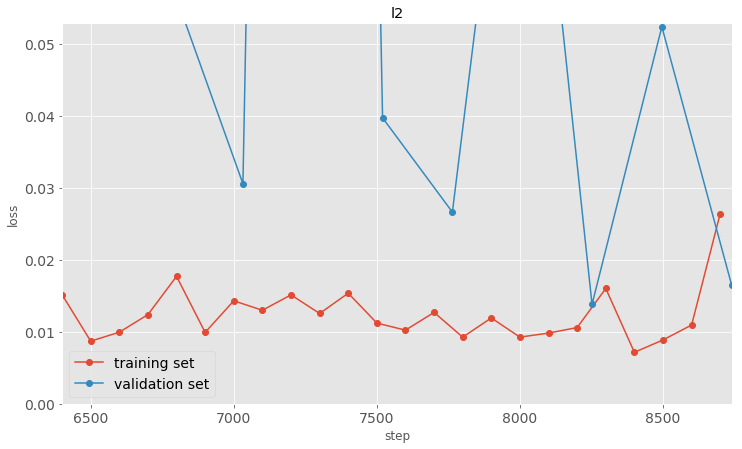

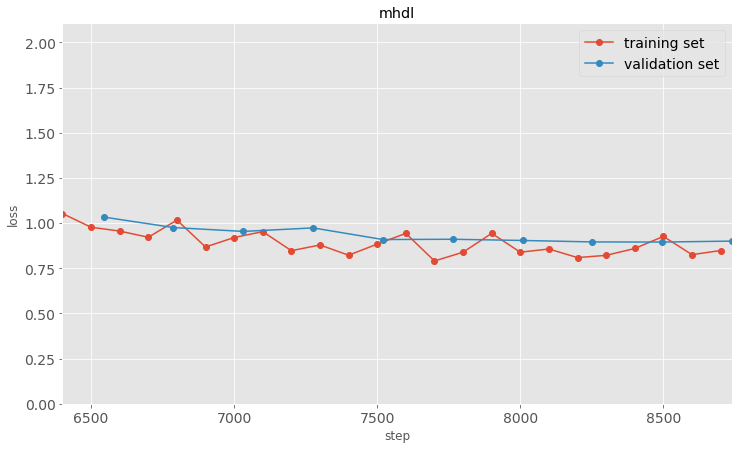

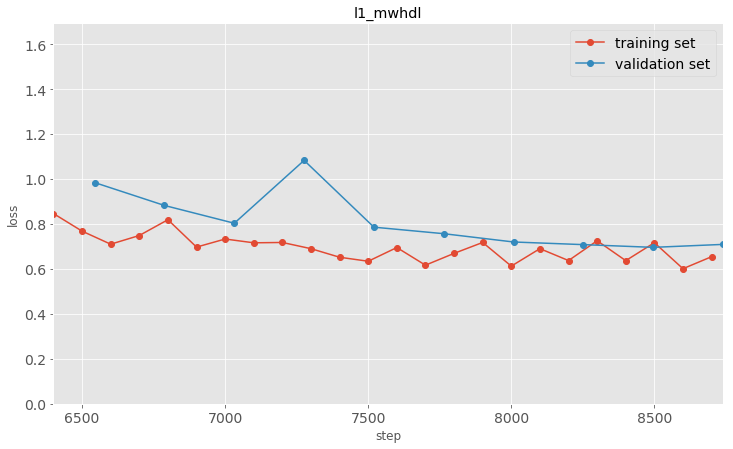

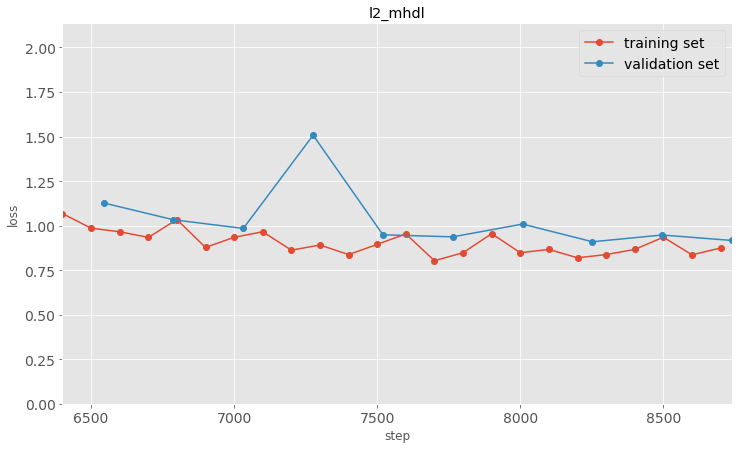

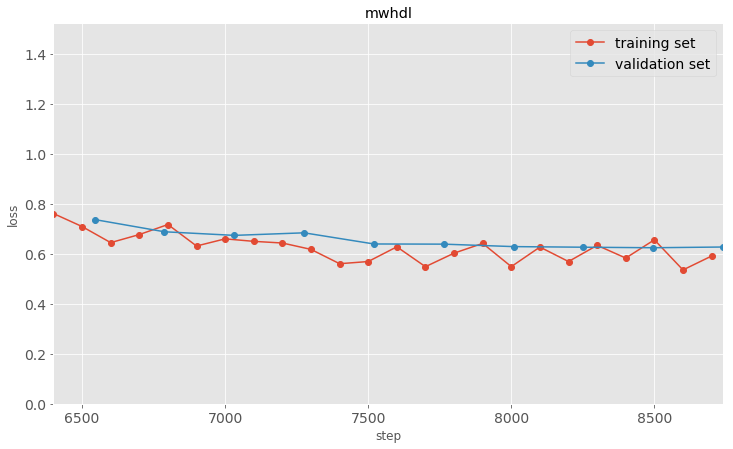

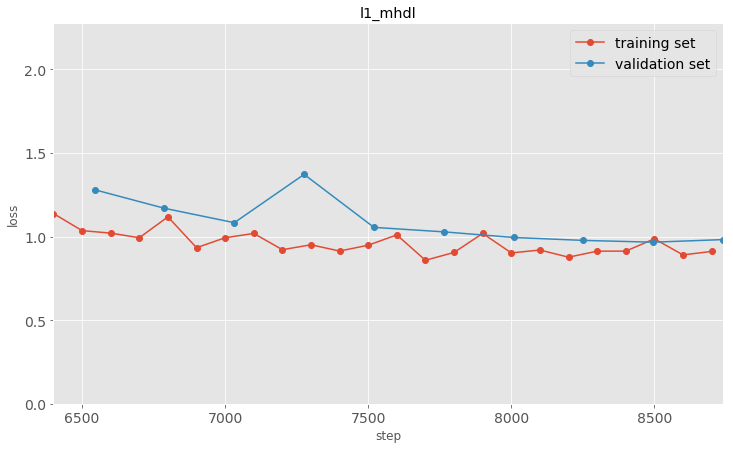

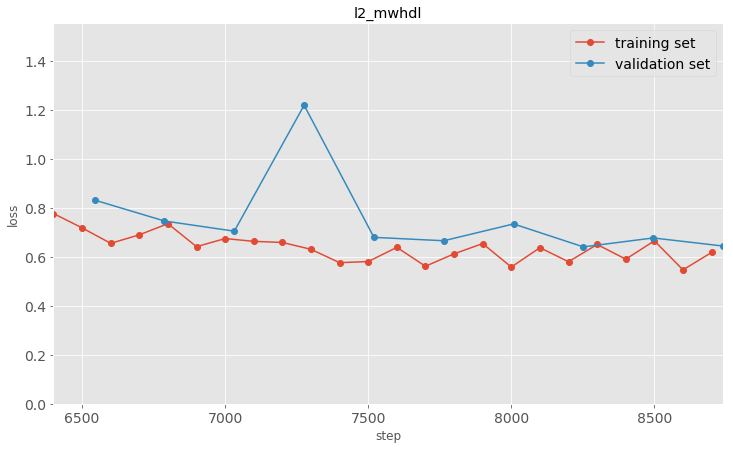

In [30]:
filepath = logs_data_path_iiw + 'slim_resnet_v1_50_deconv_decoder/l1_10mhdl'
lst = get_all_loss_model_data(data_dir=filepath,
                              exclude_sub_dirs=['2'])
dfs_train_resnet_v1_50_deconv_decoder_iiw, dfs_valid_resnet_v1_50_deconv_decoder_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_resnet_v1_50_deconv_decoder_iiw,
                 dfdict_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_resnet_v1_50_deconv_decoder_iiw, 
                    dfs_valid=dfs_valid_resnet_v1_50_deconv_decoder_iiw, 
                    logy=False, ylim_scale=2)

## vgg-16 narihira2015:

### lambda = 1.0 (mhdl)

Training loss:
df_l1 (step: 11500): 0.03229 <-> corresponding valid loss: 0.03840 (step: 11404)
df_l2 (step: 11500): 0.00250 <-> corresponding valid loss: 0.00351 (step: 11404)
df_mhdl (step: 11900): 0.77809 <-> corresponding valid loss: 0.89490 (step: 11892)
df_l1_mwhdl (step: 10600): 0.56677 <-> corresponding valid loss: 0.65285 (step: 10672)
df_l2_mhdl (step: 11900): 0.78126 <-> corresponding valid loss: 0.89805 (step: 11892)
df_mwhdl (step: 10600): 0.53061 <-> corresponding valid loss: 0.61567 (step: 10672)
df_l1_mhdl (step: 11900): 0.81410 <-> corresponding valid loss: 0.93022 (step: 11892)
df_l2_mwhdl (step: 10600): 0.53380 <-> corresponding valid loss: 0.61902 (step: 10672)

Validation loss:
df_l1 (step: 12380): 0.03531 <-> corresponding train loss: 0.03973 (step: 12300)
df_l2 (step: 12380): 0.00312 <-> corresponding train loss: 0.00392 (step: 12300)
df_mhdl (step: 12136): 0.87565 <-> corresponding train loss: 0.83274 (step: 12100)
df_l1_mwhdl (step: 12136): 0.65031 <-> correspo

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


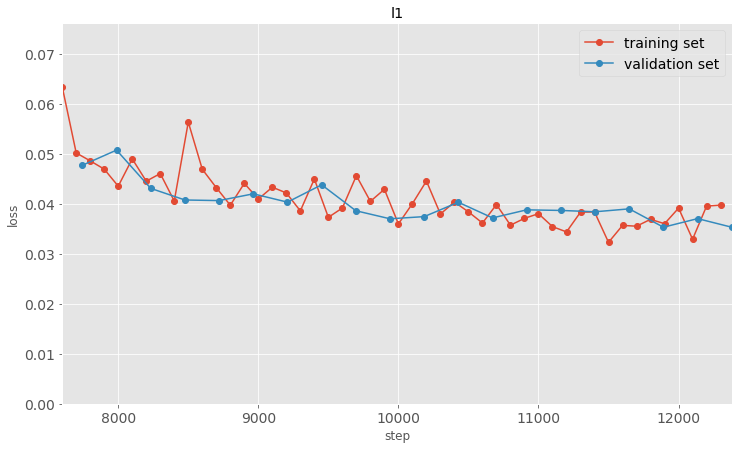

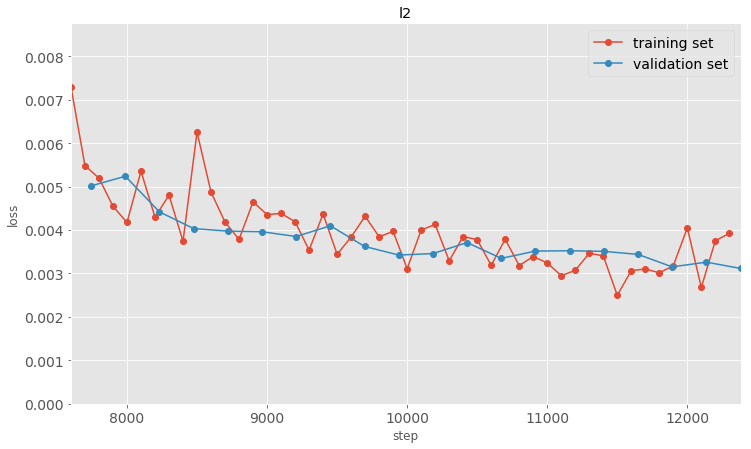

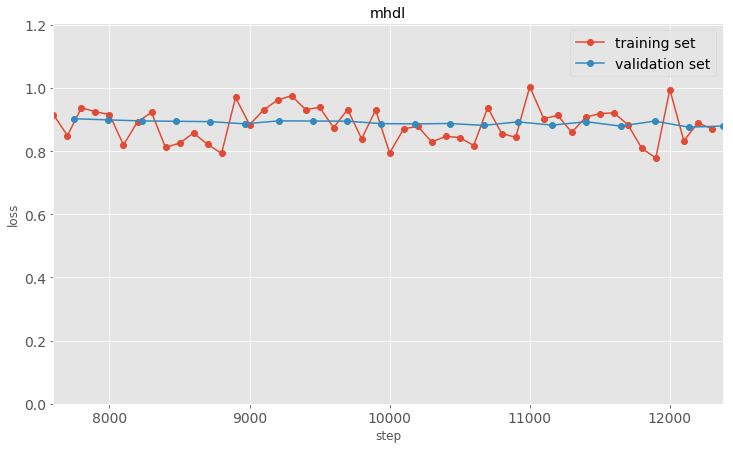

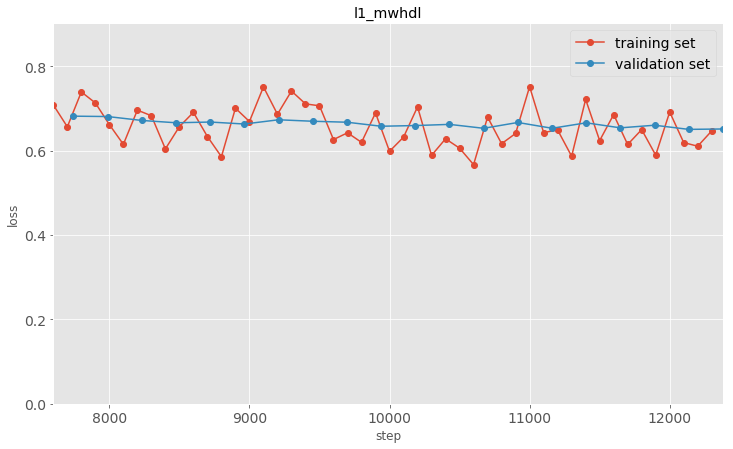

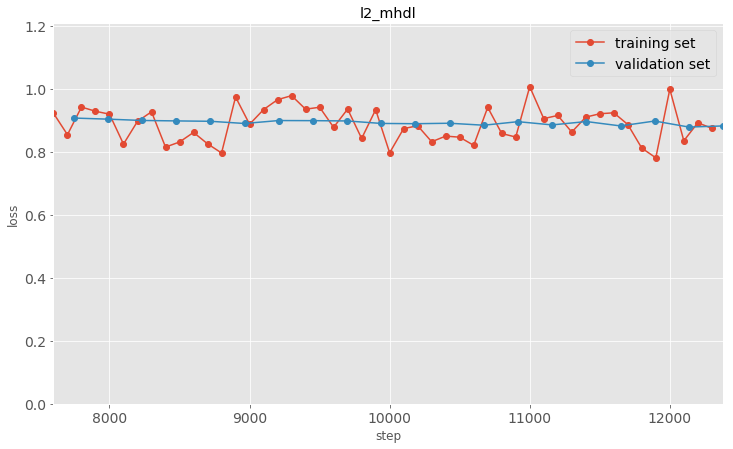

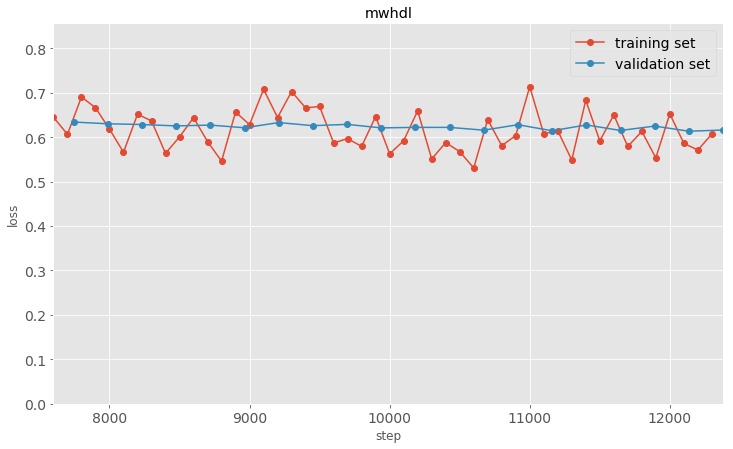

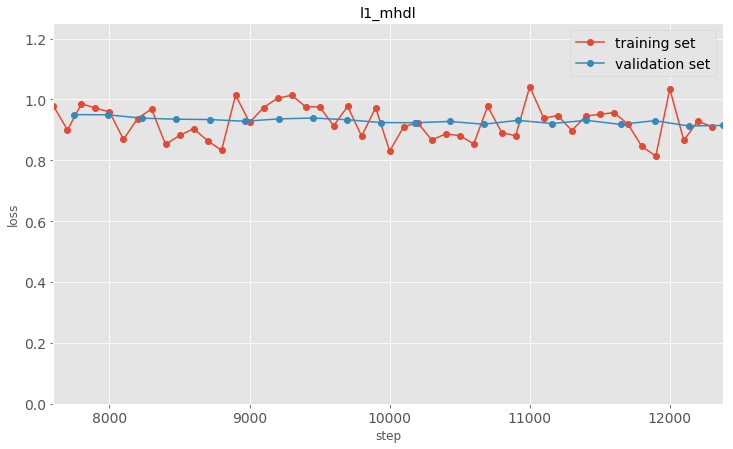

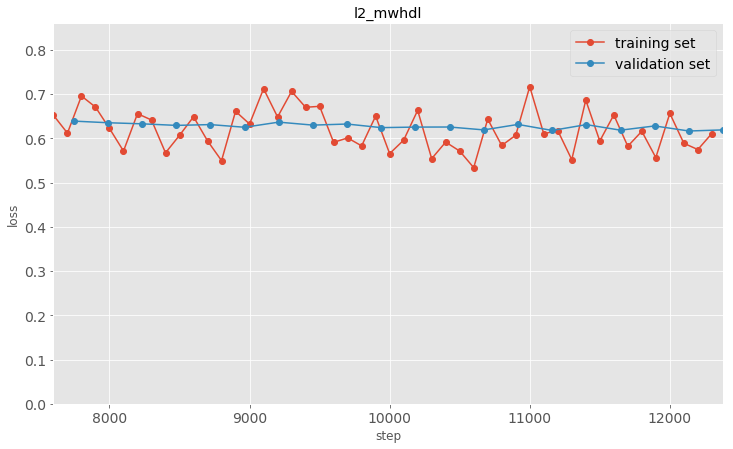

In [31]:
filepath = logs_data_path_iiw + 'slim_vgg16_narihira2015/l1_10mhdl'
lst = get_all_loss_model_data(data_dir=filepath,
                              exclude_sub_dirs=['2'])
dfs_train_vgg16_narihira2015_iiw, dfs_valid_vgg16_narihira2015_iiw = lst

get_minimum_loss(dfdict_train=dfs_train_vgg16_narihira2015_iiw,
                 dfdict_valid=dfs_valid_vgg16_narihira2015_iiw)

plot_all_loss_pairs(dfs_train=dfs_train_vgg16_narihira2015_iiw, 
                    dfs_valid=dfs_valid_vgg16_narihira2015_iiw, 
                    logy=False, ylim_scale=1.2)